## Case 1 - Deterministic
## Case 2 - DRO opt w/o $\gamma$
## Case 3 - DRO opt w $\gamma$
## Case 4 - DRO opt w DRJCC
## Case 5 - DRO opt DRJCC with ESS reserve
## Case 6 - DRO opt DRJCC with ESS reserve but without revenue
### Author: Junhyeok Kim

In [1]:
# Import the library

import os
import pandas as pd
import numpy as np
import sys
import time

import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})

In [2]:
# Define the Variables
BASE_DIR = os.getcwd()
os.chdir("../")
path = os.getcwd() 
sys.path.append(path) # 폴더 한 단계 위에서 file import 하기 위해서 sys path 설정
sys.path.append(f"{path}/src")
sys.path.append(f"{path}/src/Data_Generation")

from rts_data import generate_wind, generate_gen_dict
from aggregator import aggregator
from gurobiMILP import gurobi_MILP
from draw_fig import Single_Case_Plot

In [3]:
### Parameters
DRO_param = {'eps_joint_cvar' : 0.05}
DRO_param['theta'] = 0.05

# Vector for Bonferroni approximation
rho_vectorC = np.linspace(0, 0.0025, 26)

# Number of individual runs (number of coupled datasets in the numerical study)

IR_max = 100
IR_sim = 100

# Number of out of sample data for each individual run (N') for testing
# dataset

OOS_max = 200
OOS_sim = 100

# Number of maximum sample size (N)

N_max = 1000

# Number of sample data in training dataset (N)

N = 100;


# Total number of data 

n_total_scen = IR_max * (N_max + OOS_max)

In [4]:
# Define the Parameters

# case_dict: Generate various scenario
# res_var: Define the WT and PV as variables [True] or parameters [False]
# case:
    # case 1 : w/o uncertainty
    # case 2 : w uncertainty with DRO
    #UNIT_TIME: 1 -> 1 hour
    
case_dict = {'case':6, 'UNIT_TIME': 1, 'bid_type':'deterministic', 'n_total_scen': n_total_scen, 'N_max': N_max, 'OOS_max':OOS_max,
             'IR_max': IR_max, 'N': N, 'OOS_sim': OOS_sim, 'divide_factor': 2}

case_dict['date'] = '20220911'

nTimeslot = int(24 / case_dict['UNIT_TIME'])
char_ess = {'initSOC':0.5, 'termSOC':0.5, 'minSOC':0.2, 'maxSOC':0.8, 'efficiency':0.95}


model_dict = {'nVPP':1, 'path': path, 'N_PIECE': 10, 'nTimeslot': nTimeslot}

# Once, set te PV, WT, SMP uncertainties identically in each time (PV: 5%, WT: 10%, SMP: 10%)
uncertainty_dict = {'pv': np.ones(nTimeslot)*0.10 , 'wt': np.ones(nTimeslot)*0.10, 'smp':np.ones(nTimeslot)*0.10}


if case_dict['case']==2:
    
    model_dict['uncertainty'] = uncertainty_dict
    case_dict['bid_type'] = 'risky'
    
elif case_dict['case'] == 1:
    
    uncertainty_dict = {'pv': np.zeros(nTimeslot), 'wt': np.zeros(nTimeslot), 'smp':np.zeros(nTimeslot)}
    model_dict['uncertainty'] = uncertainty_dict
    

In [5]:
# Set Up VPP  #Unit: kW

vpp_list = []
for i in range(model_dict['nVPP']):
    nGen_dict = {'WT':4,'PV':2, 'ESS':1, 'DG':2}
    wt_list = [800, 700, 900, 1000]
    pv_list = [500, 750, 500, 700]
    ess_list = [300]
    capacity_list = [1500]
    dg_list = [300, 400, 900]
    max_list = [wt_list, pv_list, ess_list, capacity_list, dg_list]
    
    dg_dict_list = []
    for j in range(nGen_dict['DG']):
        dg_dict_list.append(generate_gen_dict(j,dg_list[j], model_dict))
    model_dict['dg_dict_list'] = dg_dict_list
    
    agg_dict = {'name': f'cvpp{i+1}', 'code': f'xds{i+1}', 'gen':nGen_dict}
    vpp_list.append(aggregator(agg_dict, char_ess, model_dict, case_dict))
    vpp_list[i].set_der_power(max_list)
    vpp_list[i].set_smp_data(case_dict['date'])
    
vpp_list[0].get_res_table()

Error
'aggregator' object has no attribute 'wt_uncert'
Aggregator set_res_table method
Uncertainty does not exist


name type  number  min_power  max_power  capacity
0   WT1_cvpp1   WT       1        0.0        800       NaN
1   WT2_cvpp1   WT       2        0.0        700       NaN
2   WT3_cvpp1   WT       3        0.0        900       NaN
3   WT4_cvpp1   WT       4        0.0       1000       NaN
4   PV5_cvpp1   PV       5        0.0        500       NaN
5   PV6_cvpp1   PV       6        0.0        750       NaN
6  ESS7_cvpp1  ESS       7     -300.0        300    1500.0
7   DG8_cvpp1   DG       8       30.0        300       NaN
8   DG9_cvpp1   DG       9       40.0        400       NaN

In [6]:
# Gurobi Optimization Model
Wmax = vpp_list[0].wt_list[0].max_power 
Wmu = vpp_list[0].wt_list[0].profile_mu
#case_dict['theta'] = DRO_param['theta']* Wmu
#case_dict['theta'] = np.reshape(case_dict['theta'], -1)
case_dict['theta'] = [DRO_param['theta']] * nTimeslot
case_dict['eps'] = DRO_param['eps_joint_cvar']
case_dict['beta'] = 0.1
case_dict['alpha_max'] = 0.2
case_dict['GRID_PIECE'] = 50
#case_dict['theta'] = np.array([0.05]*24)

opt_bid = gurobi_MILP('opt bid', vpp_list[0], model_dict, case_dict)

mip_gap = 0.0001
feas_tol = 1e-4
sol, obj_dict, P_dict, U_dict, slack_dict = opt_bid.optimize(mip_gap, feas_tol)

Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24547 rows, 56592 columns and 105078 nonzeros
Model fingerprint: 0x96aaf7f2
Model has 4800 general constraints
Variable types: 56400 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve tim


Cutting planes:
  Learned: 5
  Gomory: 29
  Cover: 104
  Implied bound: 696
  MIR: 288
  Flow cover: 594
  Inf proof: 19
  Zero half: 2
  Network: 4
  RLT: 12
  Relax-and-lift: 61
  BQP: 1

Explored 2953 nodes (61554 simplex iterations) in 5.70 seconds (5.11 work units)
Thread count was 16 (of 16 available processors)

Solution count 10: 4.33353e+06 4.32772e+06 4.18113e+06 ... 4.02819e+06

Optimal solution found (tolerance 1.00e-04)
Best objective 4.333531756367e+06, best bound 4.333531756367e+06, gap 0.0000%
Optimal Solution:
Optimization Duration Time: 5.7325098514556885


In [7]:
obj1 = obj_dict['obj1']
print(obj1)

try:
    obj2 = obj_dict['obj2']
    obj3 = obj_dict['obj3']
    print(obj2)
    print(obj3)
    
except:
    print("no obj2, obj3")

try:
    obj3_full = obj_dict['obj3_full']
except:
    pass
print(sum(obj1))
print(sum(obj2))
print(sum(obj3))

print(sum(sum(obj_dict['dg_cost'])))

print(opt_bid.m.objVal)

[ 188327.408905  186891.371695  131185.338461  131803.382557
  128836.753134  133330.823620  195890.673889  207703.513837
  182307.694523  244604.808921  192666.585201  201978.252511
  256212.114761  258229.492231  229028.705266  250984.556951
  421095.000232  415234.841116  393021.762963  390800.344397
  391144.576186  389665.680674  389255.525386  249631.090776]
[ 7190.500000  7175.500000  6605.000000  6586.500000  6589.000000
  6629.000000  7673.000000  7673.000000  7195.500000  7127.500000
  6476.500000  6476.500000  7167.000000  7194.500000  7200.000000
  7430.000000  11297.000000  12245.500000  12246.000000  12249.000000
  12246.000000  12246.000000  12246.000000  8332.000000]
[ 0.000000  0.000000 -0.000000  0.000000 -0.000000  0.000000 -0.000000
  0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000
  0.000000  0.000000  0.000000  0.000000 -0.000000  0.000000 -0.000000
  0.000000 -0.000000 -0.000000]
6159830.298191894
205496.5
1.837197061149709e-12
1620802.041825

In [8]:
print(P_dict['sum_dg'])

if opt_bid.is_dg_reserve:
    print(P_dict['dg_ru'])

[[ 210.000000  210.000000  210.000000  210.000000  210.000000  210.000000
   210.000000  210.000000  210.000000  210.000000  210.000000  210.000000
   210.000000  210.000000  210.000000  210.000000  210.000000  210.000000
   210.000000  210.000000  210.000000  210.000000  210.000000  210.000000]
 [ 240.000000  240.000000  240.000000  240.000000  240.000000  240.000000
   240.000000  240.000000  242.233586  240.000000  240.000000  240.407125
   240.000000  240.000000  240.000000  240.000000  240.000000  245.523523
   251.047045  258.313064  256.876037  261.706661  263.046381  240.000000]]
[[ 90.000000  90.000000  90.000000  90.000000  90.000000  90.000000
   90.000000  65.928205  90.000000  90.000000  80.409955  90.000000
   90.000000  90.000000  90.000000  90.000000  85.381982  90.000000
   90.000000  90.000000  90.000000  90.000000  90.000000  90.000000]
 [ 160.000000  160.000000  160.000000  160.000000  160.000000  160.000000
   160.000000  157.766414  157.766414  160.000000  159.592

In [9]:
print(P_dict['essDis'])
print(P_dict['essChg'])
if opt_bid.is_ess_reserve:
    print(P_dict['RU_essdis'])
    print(P_dict['RD_esschg'])

[[ 0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
   0.000000  0.000000  300.000000  297.977128  300.000000  300.000000
   300.000000  300.000000  300.000000  203.920983]]
[[ 0.000000  0.000000  300.000000  300.000000  300.000000  266.443500
   0.000000  0.627451  300.000000  0.000000  300.000000  300.000000
   76.608454  28.360108  196.916012  7.481095  0.000000  0.000000
   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000]]
[[ 26.572847  23.665258  0.000000  0.000000  3.192414  0.000000  1.013382
   0.000000  0.000000  0.119166  0.000000  0.000000  0.000000  0.000000
   0.000000  0.000000  0.000000  2.022872  0.000000  0.000000  0.000000
   0.000000  0.000000  0.000000]]
[[ 300.000000  300.000000  0.000000  0.000000  0.000000  33.556500
   300.000000  299.372549  0.000000  300.000000  0.000000  0.000000
   223.391546  271.639892  103.083988  292.518905  300.000000  300.000000
   30

In [10]:
if opt_bid.is_bid_DRCC:
    lhs_array, rhs_array, check_array, ratio = opt_bid.check_drcc_constraint()
    print("Ratio is :", ratio)
    for i in range(24):
        print(sum(check_array[i,:]))

Ratio is : 0.97875
100.0
100.0
100.0
100.0
100.0
96.0
96.0
96.0
96.0
96.0
96.0
96.0
96.0
96.0
96.0
96.0
96.0
97.0
100.0
100.0
100.0
100.0
100.0
100.0


In [11]:
from draw_fig import Single_Case_Plot

In [12]:
case_fig = Single_Case_Plot(vpp_list, opt_bid, model_dict, case_dict, path)

setPlotStyle()


save the fig at location : C:\Users\user\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


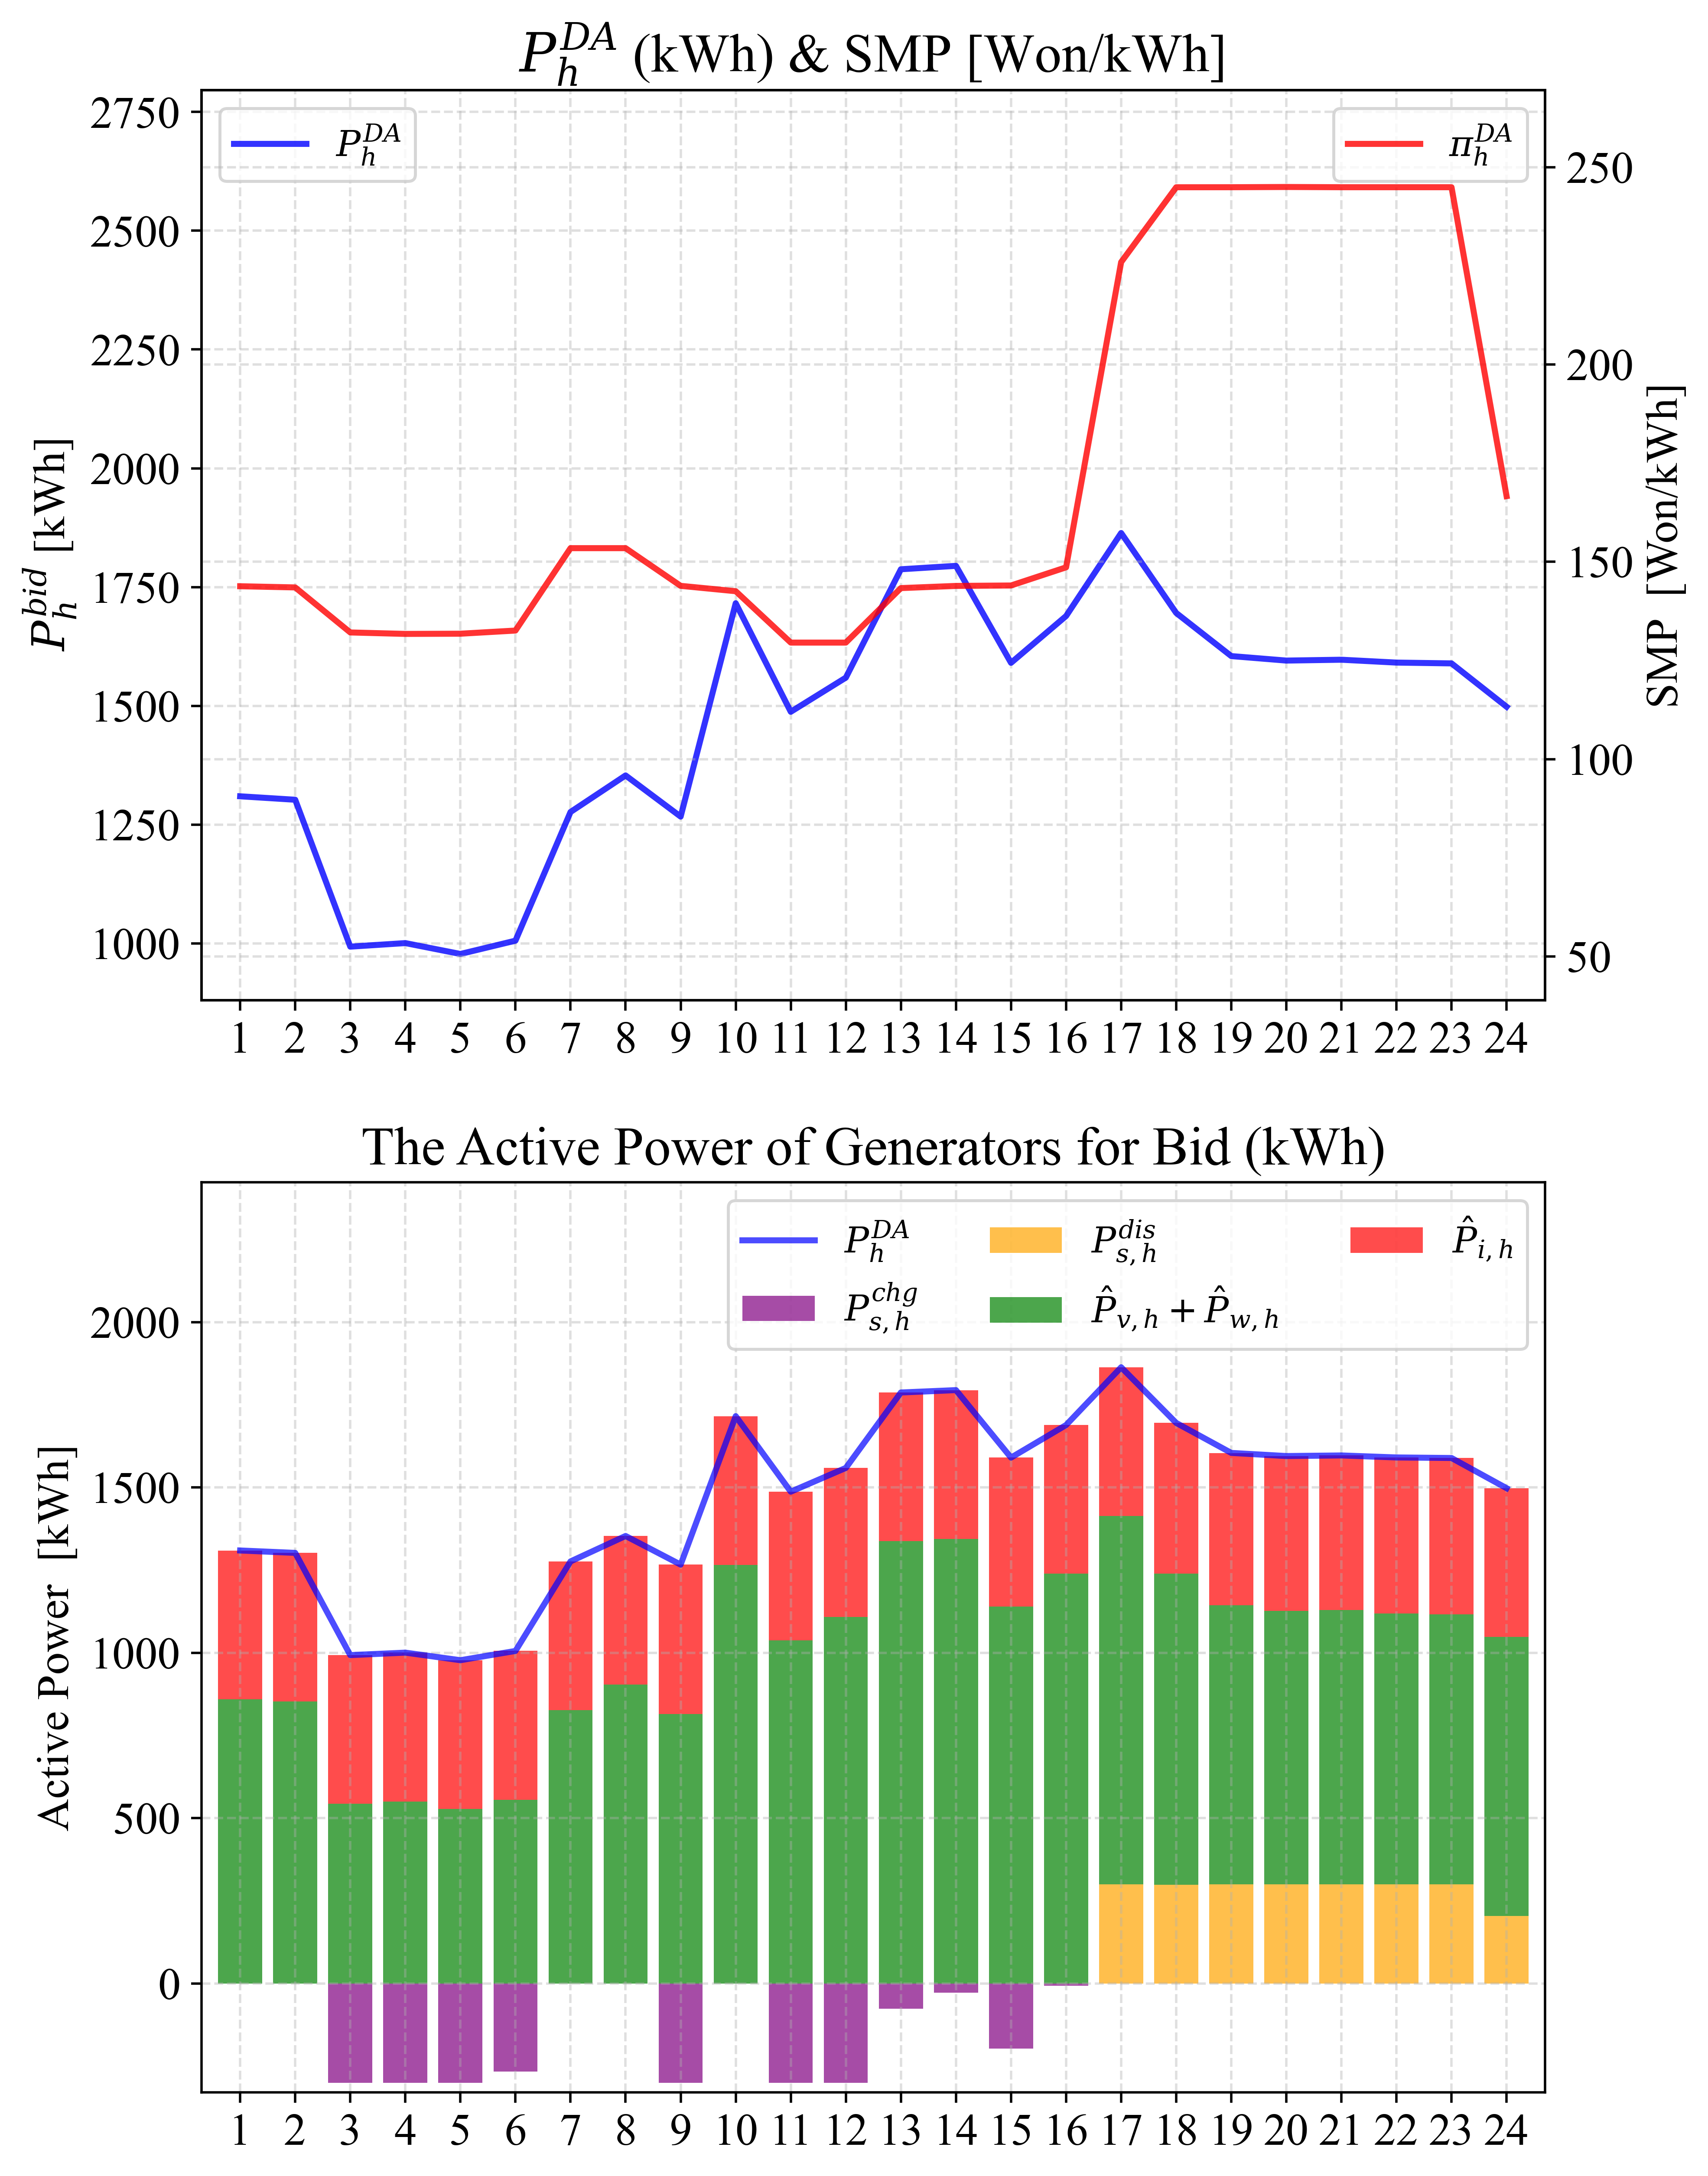

In [13]:
case_fig.make_plot(P_dict, save_flag=True)

save the fig at location : C:\Users\user\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


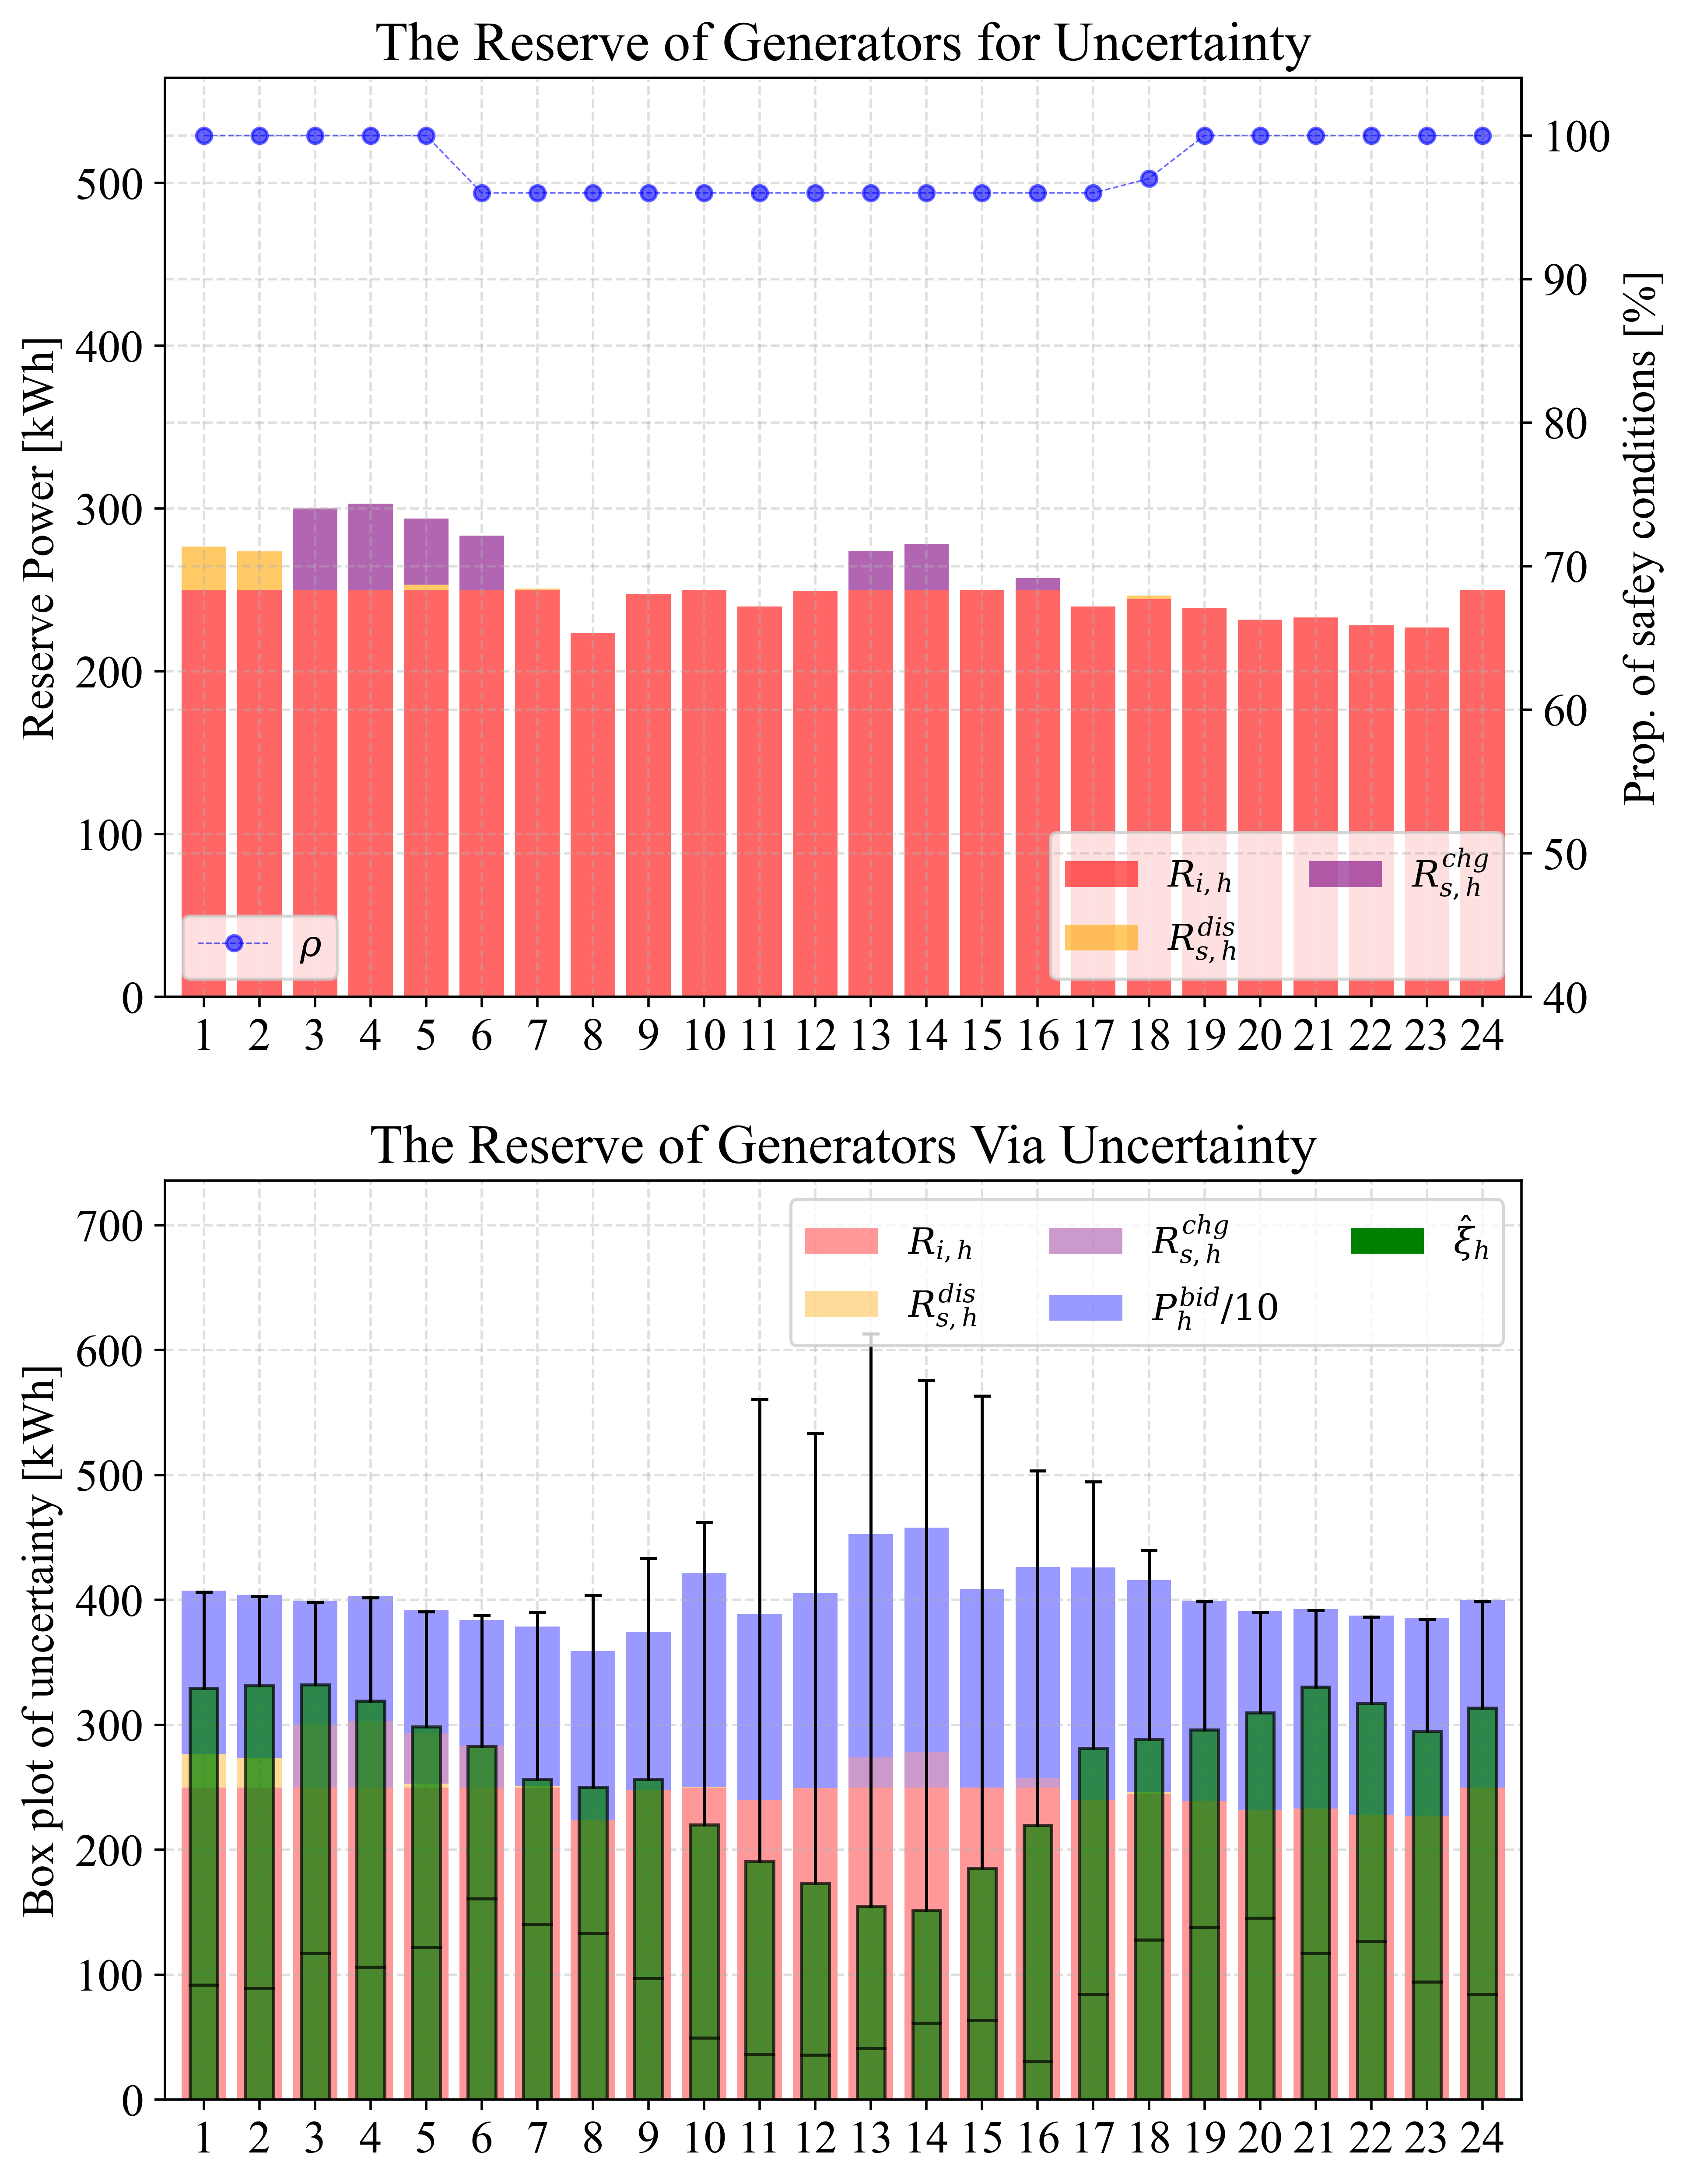

In [14]:
if opt_bid.is_ess_reserve or opt_bid.is_dg_reserve:
    case_fig.make_reserve_plot(P_dict, save_flag=True)

In [15]:
case_dict['case'] = 1


opt_bid_base = gurobi_MILP('opt bid_base', vpp_list[0], model_dict, case_dict)

mip_gap = 0.0001
feas_tol = 1e-4
sol_base, obj_dict_base, P_dict_base, U_dict_base, slack_dict_base = opt_bid_base.optimize(mip_gap, feas_tol)


case 1 add Variables
gurobi_MILP add Variables
No Uncertainty Sets in this case

Does not Cosidered alpha
Add Bid Constraint
start set_base_objectives
No Considered Any Case at base_Objectives
No obj_sum_without_bid before this
end set_base_objectives
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 427 rows, 744 columns and 5120 nonzeros
Model fingerprint: 0x50770ba5
Variable types: 552 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+02]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 6e+03]
  RHS range        [3e-01, 1e+03]
Found heuristic solution: objective 4063734.4758
Presolve removed 311 rows and 434 columns
Presolve time: 0.01s
Presolved: 116 rows, 310 columns, 1368 nonzeros
Found heuri

In [16]:

all_obj_dicts = [[None] * 10 for _ in range(10)]
all_P_dicts = [[None] * 10 for _ in range(10)]
all_U_dicts = [[None] * 10 for _ in range(10)]
all_objVal = [[None] * 10 for _ in range(10)]
all_solve_time = [[None] * 10 for _ in range(10)]
all_reliable = [[None] * 10 for _ in range(10)]
all_reliable_array = [[None] * 10 for _ in range(10)]

case_dict['case'] = 6
start_time = time.time()
for i in range(10):
    for j in range(10):
        print("*"*30)
        print("iterion i,j :", i,j)
        print("iterion i,j :", i,j)
        print("iterion i,j :", i,j)
        print("*"*30)
        DRO_param['eps_joint_cvar'] = i*0.01 + 0.01
        DRO_param['theta'] = j*0.01 + 0.01
        
        
        # Gurobi Optimization Model
        case_dict['theta'] = [DRO_param['theta']] * nTimeslot
        case_dict['eps'] = DRO_param['eps_joint_cvar']
        #case_dict['theta'] = np.array([0.05]*24)

        opt_bid = gurobi_MILP(f'opt bid{i}_{j}', vpp_list[0], model_dict, case_dict)
        sol, obj_dict, P_dict, U_dict, slack_dict = opt_bid.optimize(mip_gap, feas_tol)
        
        all_obj_dicts[i][j] = obj_dict
        all_P_dicts[i][j] = P_dict
        all_U_dicts[i][j] = U_dict
        all_objVal[i][j] = opt_bid.m.objVal
        all_solve_time[i][j] = opt_bid.opt_solve_time
        if opt_bid.is_bid_DRCC:
            lhs_array, rhs_array, check_array, ratio = opt_bid.check_drcc_constraint()
            all_reliable_array[i][j] = check_array
            all_reliable[i][j] = ratio * 100
        else:
            print("No is_bid_DRCC")
            
end_time = time.time()
total_solution_time = end_time - start_time

******************************
iterion i,j : 0 0
iterion i,j : 0 0
iterion i,j : 0 0
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24547 rows, 56592 columns and 105078 nonzeros
Model fingerprint: 0x0e1f3227
Model has 4800 general constraints
Variable types: 56400 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds r

H    0     0                    4165299.7251 4165821.44  0.01%     -    0s

Cutting planes:
  Learned: 2
  Flow cover: 2

Explored 1 nodes (230 simplex iterations) in 0.15 seconds (0.15 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 4.1653e+06 4.13393e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.165299725139e+06, best bound 4.165299725139e+06, gap 0.0000%
Optimal Solution:
Optimization Duration Time: 0.17197561264038086
******************************
iterion i,j : 0 4
iterion i,j : 0 4
iterion i,j : 0 4
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build

Presolve removed 24100 rows and 55779 columns
Presolve time: 0.13s
Presolved: 447 rows, 813 columns, 6029 nonzeros
Variable types: 649 continuous, 164 integer (164 binary)

Root relaxation: objective 3.982412e+06, 250 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3982412.38    0    2          - 3982412.38      -     -    0s
H    0     0                    3953174.9744 3982412.38  0.74%     -    0s
H    0     0                    3981928.7831 3982412.38  0.01%     -    0s

Cutting planes:
  Learned: 2
  Gomory: 1
  MIR: 1
  Flow cover: 2

Explored 1 nodes (250 simplex iterations) in 0.16 seconds (0.14 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 3.98193e+06 3.95317e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.981928783102e+06, best bound 3.982246655131e+06, gap 0.0080%
Op

     0     0 4472465.08    0   84          - 4472465.08      -     -    2s
     0     0 4469219.95    0   69          - 4469219.95      -     -    2s
     0     0 4426262.73    0   58          - 4426262.73      -     -    2s
     0     0 4425930.14    0   61          - 4425930.14      -     -    2s
     0     0 4425819.52    0   62          - 4425819.52      -     -    2s
     0     0 4425804.21    0   61          - 4425804.21      -     -    2s
     0     0 4424009.94    0   55          - 4424009.94      -     -    2s
     0     0 4408730.85    0   43          - 4408730.85      -     -    2s
     0     0 4408420.65    0   43          - 4408420.65      -     -    2s
     0     0 4408420.62    0   43          - 4408420.62      -     -    2s
     0     0 4408022.46    0   41          - 4408022.46      -     -    2s
H    0     0                    4219715.7804 4408022.46  4.46%     -    2s
     0     0 4404302.34    0   36 4219715.78 4404302.34  4.37%     -    2s
     0     0 4404279.48  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4694177.52    0 1018          - 4694177.52      -     -    0s
     0     0 4547795.55    0  540          - 4547795.55      -     -    1s
     0     0 4454092.29    0  297          - 4454092.29      -     -    1s
     0     0 4448166.93    0  218          - 4448166.93      -     -    1s
     0     0 4448166.93    0  197          - 4448166.93      -     -    1s
     0     0 4438689.83    0  166          - 4438689.83      -     -    1s
     0     0 4398033.92    0   79          - 4398033.92      -     -    1s
     0     0 4368756.56    0   63          - 4368756.56      -     -    1s
     0     0 4368470.48    0   56          - 4368470.48      -     -    1s
     0     0 4368387.73    0   56          - 4368387.73      -     -    1s
     0     0 4359027.32    0   40          - 4359027.32      -     -    1s
     0     0 4324746.99

     0     0 4241715.34    0   29          - 4241715.34      -     -    2s
     0     0 4241691.23    0   29          - 4241691.23      -     -    2s
     0     0 4232782.20    0   27          - 4232782.20      -     -    2s
H    0     0                    4210269.3016 4232782.20  0.53%     -    2s
     0     0 4218834.96    0   16 4210269.30 4218834.96  0.20%     -    2s
     0     0 4217012.57    0   14 4210269.30 4217012.57  0.16%     -    2s
     0     0 4215757.34    0   13 4210269.30 4215757.34  0.13%     -    2s
     0     0 4214875.45    0   12 4210269.30 4214875.45  0.11%     -    2s
     0     0 4214291.91    0   12 4210269.30 4214291.91  0.10%     -    2s
     0     0 4214161.73    0   12 4210269.30 4214161.73  0.09%     -    2s
     0     0 4212299.44    0   10 4210269.30 4212299.44  0.05%     -    2s
     0     0 4211972.53    0    4 4210269.30 4211972.53  0.04%     -    2s
     0     0 4211966.76    0    4 4210269.30 4211966.76  0.04%     -    2s
     0     0 4210366.36  

     0     0 4122851.51    0    2 4122145.27 4122851.51  0.02%     -    2s
     0     0 4122201.71    0    1 4122145.27 4122201.71  0.00%     -    2s

Cutting planes:
  Gomory: 92
  Cover: 22
  Implied bound: 447
  Clique: 226
  MIR: 34
  Flow cover: 36
  RLT: 1
  Relax-and-lift: 16
  BQP: 4
  PSD: 98

Explored 1 nodes (11547 simplex iterations) in 2.27 seconds (2.09 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 4.12215e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.122145269648e+06, best bound 4.122201712948e+06, gap 0.0014%
Optimal Solution:
Optimization Duration Time: 2.3690006732940674
******************************
iterion i,j : 1 7
iterion i,j : 1 7
iterion i,j : 1 7
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of s

Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.49s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types: 5513 continuous, 1384 integer (1384 binary)

Root relaxation: objective 4.406482e+06, 3414 iterations, 0.04 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4406482.42    0 1016          - 4406482.42      -     -    1s
     0     0 4405046.72    0 1041          - 4405046.72      -     -    1s
     0     0 4176983.37    0  313          - 4176983.37      -     -    2s
     0     0 4137203.83    0  226          - 4137203.83      -     -    2s
     0     0 4101908.66    0  216          - 4101908.66      -     -    2s
     0     0 4063118.18    0   88          - 

     0     0 4480803.17    0  113          - 4480803.17      -     -    3s
     0     0 4480778.51    0  113          - 4480778.51      -     -    3s
     0     0 4480674.60    0  113          - 4480674.60      -     -    3s
     0     0 4480632.17    0  113          - 4480632.17      -     -    3s
     0     0 4480629.76    0  113          - 4480629.76      -     -    3s
     0     0 4480607.16    0  113          - 4480607.16      -     -    3s
H    0     0                    3750343.9519 4480607.16  19.5%     -    3s
     0     0 4480607.16    0  113 3750343.95 4480607.16  19.5%     -    3s
     0     1 4480607.16    0  113 3750343.95 4480607.16  19.5%     -    3s
H   27    20                    3754266.7814 4433992.34  18.1%  40.3    3s
H   28    20                    3881049.8010 4430099.26  14.1%  39.8    3s
H  115    74                    3942699.4376 4429619.68  12.3%  15.4    3s
H  125    74                    3946863.9977 4429619.68  12.2%  14.7    3s
H  134    74             

H   36    32                    3783369.4915 4381816.49  15.8%  14.9    2s
H  113   104                    3985643.9523 4381514.67  9.93%   7.4    2s
H  116   104                    4077340.0934 4381514.67  7.46%   7.3    2s
H  167   138                    4086918.4130 4381514.67  7.21%   6.7    2s
H  168   138                    4089903.6136 4381514.67  7.13%   6.6    2s
H  172   138                    4124453.0993 4381514.67  6.23%   6.6    2s
H  180   138                    4316828.9711 4381514.67  1.50%   6.6    2s
*  269   156              27    4316873.2768 4381449.00  1.50%   5.7    3s
H  293   175                    4370396.8227 4380650.80  0.23%   5.7    3s
*  356   200              27    4373796.8632 4380650.80  0.16%   6.2    3s
*  403   200              29    4374951.3483 4380650.80  0.13%   6.1    3s
*  420   196              29    4377082.1130 4380650.80  0.08%   6.0    3s

Cutting planes:
  Learned: 6
  Gomory: 42
  Cover: 11
  Implied bound: 275
  MIR: 105
  Flow cover:


Root relaxation: objective 4.653078e+06, 3470 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4653078.22    0 1015          - 4653078.22      -     -    0s
     0     0 4645248.75    0 1042          - 4645248.75      -     -    1s
     0     0 4598797.54    0  982          - 4598797.54      -     -    1s
     0     0 4428406.00    0  326          - 4428406.00      -     -    1s
     0     0 4424954.86    0  259          - 4424954.86      -     -    1s
     0     0 4424954.86    0  259          - 4424954.86      -     -    1s
     0     0 4418627.43    0  260          - 4418627.43      -     -    1s
     0     0 4418627.43    0  271          - 4418627.43      -     -    1s
     0     0 4413287.39    0  196          - 4413287.39      -     -    1s
     0     0 4400936.84    0  163          - 4400936.84      -     -    1s
     0  

     0     0 4338673.04    0   69          - 4338673.04      -     -    2s
     0     0 4338671.20    0   69          - 4338671.20      -     -    2s
     0     0 4337245.32    0   72          - 4337245.32      -     -    2s
     0     0 4309949.67    0   59          - 4309949.67      -     -    2s
     0     0 4309127.42    0   60          - 4309127.42      -     -    2s
     0     0 4308628.50    0   60          - 4308628.50      -     -    2s
     0     0 4308567.77    0   60          - 4308567.77      -     -    2s
     0     0 4308567.77    0   60          - 4308567.77      -     -    2s
     0     0 4307212.43    0   61          - 4307212.43      -     -    2s
     0     0 4302205.03    0   58          - 4302205.03      -     -    2s
     0     0 4302070.43    0   56          - 4302070.43      -     -    2s
     0     0 4301922.63    0   56          - 4301922.63      -     -    2s
     0     0 4301906.70    0   56          - 4301906.70      -     -    2s
     0     0 4300657.20  

     0     0 4210100.26    0   25 4202682.44 4210100.26  0.18%     -    2s
     0     0 4210097.69    0   25 4202682.44 4210097.69  0.18%     -    2s
     0     0 4210096.42    0   25 4202682.44 4210096.42  0.18%     -    2s
     0     0 4210088.92    0   26 4202682.44 4210088.92  0.18%     -    2s
     0     0 4210088.92    0   26 4202682.44 4210088.92  0.18%     -    2s
     0     0 4210088.92    0   37 4202682.44 4210088.92  0.18%     -    2s
     0     0 4205773.76    0   20 4202682.44 4205773.76  0.07%     -    2s
     0     0 4204611.90    0   12 4202682.44 4204611.90  0.05%     -    2s
     0     0 4204162.36    0   12 4202682.44 4204162.36  0.04%     -    2s
     0     0 4204162.36    0   12 4202682.44 4204162.36  0.04%     -    2s
     0     0 4203169.44    0   11 4202682.44 4203169.44  0.01%     -    2s
     0     0 4202744.44    0    3 4202682.44 4202744.44  0.00%     -    2s

Cutting planes:
  Gomory: 24
  Implied bound: 2
  MIR: 8
  Flow cover: 7
  Relax-and-lift: 3

Explo

  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.33s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types: 5513 continuous, 1384 integer (1384 binary)

Root relaxation: objective 4.488681e+06, 3323 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4488681.02    0 1020          - 4488681.02      -     -    0s
     0     0 4413298.34    0  606          - 4413298.34      -     -    1s
     0     0 4276999.66    0  360          - 4276999.66      -     -    1s
     0     0 4247404.57    0  212          - 4247404.57      -     -    1s
     0     0 4247404.57    0  215          - 4247404.57      -     -    1s
     0     0 4241145.90    0  174          - 4241145.90      -     -    1s
     0     0 4228894.24    0  111          - 4228894.24      -     -    1s
     0     0 4226951.

     0     0 4087602.43    0   39 4021997.30 4087602.43  1.63%     -    2s
     0     0 4083421.66    0   17 4021997.30 4083421.66  1.53%     -    2s
     0     0 4083234.89    0   18 4021997.30 4083234.89  1.52%     -    2s
     0     0 4083138.49    0   18 4021997.30 4083138.49  1.52%     -    2s
     0     0 4082088.03    0   21 4021997.30 4082088.03  1.49%     -    2s
     0     0 4081145.67    0   21 4021997.30 4081145.67  1.47%     -    2s
     0     0 4079543.92    0   18 4021997.30 4079543.92  1.43%     -    2s
     0     0 4079483.81    0   18 4021997.30 4079483.81  1.43%     -    2s
H    0     0                    4026923.3262 4079483.81  1.31%     -    2s
     0     0 4079480.81    0   18 4026923.33 4079480.81  1.31%     -    2s
     0     0 4079464.11    0   19 4026923.33 4079464.11  1.30%     -    2s
H    0     0                    4027508.5017 4079464.11  1.29%     -    2s
     0     0 4079464.11    0   19 4027508.50 4079464.11  1.29%     -    2s
     0     0 4079464.11  

H    0     0                    4029114.5715 4029493.63  0.01%     -    3s

Cutting planes:
  Gomory: 13
  Implied bound: 3
  MIR: 23
  Flow cover: 21
  Inf proof: 1
  RLT: 1
  Relax-and-lift: 4

Explored 1 nodes (18125 simplex iterations) in 3.73 seconds (3.12 work units)
Thread count was 16 (of 16 available processors)

Solution count 4: 4.02911e+06 3.97056e+06 3.94561e+06 3.93858e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.029114571467e+06, best bound 4.029138135922e+06, gap 0.0006%
Optimal Solution:
Optimization Duration Time: 3.7530016899108887
******************************
iterion i,j : 3 0
iterion i,j : 3 0
iterion i,j : 3 0
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end se

     0     0 4484779.15    0  229 3835081.09 4484779.15  16.9%     -    4s
     0     0 4484779.15    0  228 3835081.09 4484779.15  16.9%     -    4s
H    0     0                    3873945.8650 4484779.15  15.8%     -    4s
     0     0 4484779.15    0  200 3873945.87 4484779.15  15.8%     -    5s
     0     0 4484779.15    0  191 3873945.87 4484779.15  15.8%     -    5s
     0     0 4484779.15    0  193 3873945.87 4484779.15  15.8%     -    5s
     0     0 4484779.15    0  192 3873945.87 4484779.15  15.8%     -    5s
H    0     0                    3957859.5232 4484779.15  13.3%     -    5s
     0     0 4484779.15    0  192 3957859.52 4484779.15  13.3%     -    5s
     0     0 4484779.15    0  184 3957859.52 4484779.15  13.3%     -    5s
     0     0 4484779.15    0  181 3957859.52 4484779.15  13.3%     -    5s
     0     0 4484779.15    0  181 3957859.52 4484779.15  13.3%     -    5s
     0     0 4484779.15    0  182 3957859.52 4484779.15  13.3%     -    5s
     0     0 4484779.15  

     0     0 4437342.40    0  156          - 4437342.40      -     -    3s
     0     0 4437280.60    0  157          - 4437280.60      -     -    3s
     0     0 4437280.22    0  157          - 4437280.22      -     -    3s
     0     0 4437204.12    0  158          - 4437204.12      -     -    3s
H    0     0                    3708797.4548 4437204.12  19.6%     -    3s
     0     0 4437204.12    0  158 3708797.45 4437204.12  19.6%     -    3s
H    0     0                    3842109.0102 4437204.12  15.5%     -    3s
     0     2 4437204.12    0  158 3842109.01 4437204.12  15.5%     -    3s
H   26     3                    3882184.9828 4431396.11  14.1%  38.9    3s
H   27     3                    3886656.6475 4431396.11  14.0%  38.9    3s
H   57     8                    3940308.6121 4427946.52  12.4%  40.6    3s
H   61     8                    3943889.7663 4423959.34  12.2%  40.5    3s
H  137    68                    4058544.1362 4416688.92  8.82%  31.2    3s
H  142    68             

end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24547 rows, 56592 columns and 105078 nonzeros
Model fingerprint: 0xd20cd10b
Model has 4800 general constraints
Variable types: 56400 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.33s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types

H   32    14                    3842727.3575 4299206.38  11.9%   8.1    3s
H   35    14                    3867213.5082 4299150.30  11.2%   8.5    3s
H   37    14                    3883315.1425 4299150.30  10.7%   9.8    3s
H  122    87                    4042003.1446 4298262.57  6.34%  12.9    3s
H  139    87                    4074419.5564 4298262.57  5.49%  12.5    3s
H  177   108                    4123724.9310 4298262.57  4.23%  10.6    3s
H  178   108                    4125343.5044 4298262.57  4.19%  10.6    3s
*  247   117              31    4216261.8705 4298262.57  1.94%   9.3    3s
*  248   117              31    4217595.8517 4298262.57  1.91%   9.3    3s
H  249   117                    4217968.2675 4298262.57  1.90%   9.3    3s
*  287   126              32    4254038.1196 4298262.57  1.04%   8.5    3s
*  328   126              34    4254670.2228 4298262.57  1.02%   8.4    3s
*  454   186              30    4278944.5554 4289650.91  0.25%   8.0    3s
*  521   204             

     0     0 4253939.57    0   50 4210439.16 4253939.57  1.03%     -    3s
     0     0 4253902.37    0   50 4210439.16 4253902.37  1.03%     -    3s
     0     0 4253899.69    0   50 4210439.16 4253899.69  1.03%     -    3s
     0     0 4253891.49    0   50 4210439.16 4253891.49  1.03%     -    3s
     0     0 4251615.07    0   46 4210439.16 4251615.07  0.98%     -    3s
     0     0 4250823.10    0   45 4210439.16 4250823.10  0.96%     -    3s
     0     0 4250218.87    0   45 4210439.16 4250218.87  0.94%     -    3s
     0     0 4250218.87    0   45 4210439.16 4250218.87  0.94%     -    3s
     0     0 4250218.87    0   45 4210439.16 4250218.87  0.94%     -    3s
     0     0 4249871.44    0   44 4210439.16 4249871.44  0.94%     -    3s
H    0     0                    4241929.7091 4249871.44  0.19%     -    3s
     0     0 4246680.26    0   33 4241929.71 4246680.26  0.11%     -    3s
     0     0 4246669.18    0   31 4241929.71 4246669.18  0.11%     -    3s
     0     0 4246604.46  

     0     0 4268004.65    0  102          - 4268004.65      -     -    3s
     0     0 4267976.28    0  103          - 4267976.28      -     -    3s
     0     0 4267973.50    0  103          - 4267973.50      -     -    3s
     0     0 4262494.27    0  101          - 4262494.27      -     -    3s
     0     0 4262227.88    0   96          - 4262227.88      -     -    3s
     0     0 4262219.23    0   96          - 4262219.23      -     -    3s
     0     0 4261686.67    0   92          - 4261686.67      -     -    3s
     0     0 4255269.90    0   90          - 4255269.90      -     -    3s
     0     0 4254934.40    0   90          - 4254934.40      -     -    3s
     0     0 4254896.56    0   90          - 4254896.56      -     -    3s
     0     0 4254890.42    0   90          - 4254890.42      -     -    3s
     0     0 4253124.28    0   87          - 4253124.28      -     -    3s
     0     0 4223647.12    0   62          - 4223647.12      -     -    3s
     0     0 4223396.62  

     0     0 4234130.68    0  124          - 4234130.68      -     -    2s
     0     0 4233580.50    0  124          - 4233580.50      -     -    2s
     0     0 4233580.27    0  123          - 4233580.27      -     -    2s
     0     0 4233549.68    0  122          - 4233549.68      -     -    2s
     0     0 4233546.33    0  121          - 4233546.33      -     -    2s
     0     0 4233303.16    0  123          - 4233303.16      -     -    2s
     0     0 4233275.96    0  122          - 4233275.96      -     -    2s
     0     0 4233262.79    0  121          - 4233262.79      -     -    2s
     0     0 4233260.98    0  121          - 4233260.98      -     -    2s
     0     0 4233125.98    0  109          - 4233125.98      -     -    2s
     0     0 4233036.63    0  110          - 4233036.63      -     -    2s
     0     0 4233033.60    0  110          - 4233033.60      -     -    2s
     0     0 4232892.31    0  116          - 4232892.31      -     -    2s
     0     0 4228703.06  

     0     0 4195896.51    0  144          - 4195896.51      -     -    2s
     0     0 4195612.93    0  144          - 4195612.93      -     -    2s
     0     0 4195396.39    0  144          - 4195396.39      -     -    2s
     0     0 4195389.91    0  144          - 4195389.91      -     -    2s
     0     0 4195389.84    0  144          - 4195389.84      -     -    2s
     0     0 4192999.11    0  120          - 4192999.11      -     -    2s
     0     0 4191898.60    0  116          - 4191898.60      -     -    3s
     0     0 4191650.61    0  129          - 4191650.61      -     -    3s
     0     0 4191560.75    0  131          - 4191560.75      -     -    3s
     0     0 4191552.37    0  130          - 4191552.37      -     -    3s
     0     0 4189442.98    0  122          - 4189442.98      -     -    3s
     0     0 4187837.79    0  115          - 4187837.79      -     -    3s
     0     0 4187117.09    0  115          - 4187117.09      -     -    3s
     0     0 4186946.95  

     0     0 4144069.13    0  144          - 4144069.13      -     -    1s
     0     0 4144069.13    0  145          - 4144069.13      -     -    1s
     0     0 4144069.13    0  145          - 4144069.13      -     -    1s
     0     0 4143925.65    0  143          - 4143925.65      -     -    1s
     0     0 4143925.65    0  129          - 4143925.65      -     -    1s
     0     0 4143925.65    0  127          - 4143925.65      -     -    1s
     0     0 4143925.65    0  127          - 4143925.65      -     -    1s
     0     0 4143925.65    0  127          - 4143925.65      -     -    1s
     0     0 4143925.65    0  127          - 4143925.65      -     -    1s
     0     0 4142520.55    0  112          - 4142520.55      -     -    1s
     0     0 4141716.65    0  105          - 4141716.65      -     -    2s
     0     0 4137741.76    0  103          - 4137741.76      -     -    2s
     0     0 4137741.76    0  103          - 4137741.76      -     -    2s
     0     0 4137741.76  

     0     0 4541596.67    0  270          - 4541596.67      -     -    3s
     0     0 4541546.53    0  268          - 4541546.53      -     -    3s
     0     0 4541524.18    0  270          - 4541524.18      -     -    3s
     0     0 4541520.42    0  269          - 4541520.42      -     -    3s
     0     0 4541367.93    0  270          - 4541367.93      -     -    3s
     0     0 4541310.64    0  272          - 4541310.64      -     -    3s
     0     0 4541304.62    0  272          - 4541304.62      -     -    3s
     0     0 4541252.25    0  275          - 4541252.25      -     -    3s
H    0     0                    4084195.6478 4541252.25  11.2%     -    3s
     0     0 4541247.24    0  275 4084195.65 4541247.24  11.2%     -    3s
H    0     0                    4154785.1464 4541080.80  9.30%     -    4s
     0     2 4541080.80    0  272 4154785.15 4541080.80  9.30%     -    4s
H   31    26                    4159326.3942 4540266.10  9.16%   112    4s
H   32    26             

  Relax-and-lift: 117
  PSD: 1

Explored 4442 nodes (93036 simplex iterations) in 9.13 seconds (6.72 work units)
Thread count was 16 (of 16 available processors)

Solution count 10: 4.46105e+06 4.46104e+06 4.46104e+06 ... 4.05279e+06

Optimal solution found (tolerance 1.00e-04)
Best objective 4.461051038120e+06, best bound 4.461051038120e+06, gap 0.0000%
Optimal Solution:
Optimization Duration Time: 9.157975196838379
******************************
iterion i,j : 4 2
iterion i,j : 4 2
iterion i,j : 4 2
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K


Root relaxation: objective 4.653078e+06, 3890 iterations, 0.04 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4653078.22    0 1012          - 4653078.22      -     -    1s
     0     0 4584739.34    0  703          - 4584739.34      -     -    2s
     0     0 4512455.04    0  559          - 4512455.04      -     -    2s
     0     0 4446867.96    0  318          - 4446867.96      -     -    2s
     0     0 4446867.96    0  348          - 4446867.96      -     -    2s
     0     0 4438699.95    0  284          - 4438699.95      -     -    2s
     0     0 4427351.55    0  269          - 4427351.55      -     -    2s
     0     0 4426934.83    0  264          - 4426934.83      -     -    2s
     0     0 4426901.20    0  265          - 4426901.20      -     -    2s
     0     0 4426883.96    0  265          - 4426883.96      -     -    2s
     0  

     0     0 4379558.81    0  245          - 4379558.81      -     -    2s
     0     0 4379535.63    0  245          - 4379535.63      -     -    2s
     0     0 4379533.16    0  245          - 4379533.16      -     -    2s
     0     0 4376514.58    0  229          - 4376514.58      -     -    2s
     0     0 4376153.79    0  234          - 4376153.79      -     -    2s
     0     0 4376091.90    0  234          - 4376091.90      -     -    2s
     0     0 4376063.90    0  233          - 4376063.90      -     -    2s
     0     0 4375874.74    0  229          - 4375874.74      -     -    2s
     0     0 4375844.53    0  230          - 4375844.53      -     -    2s
     0     0 4375783.67    0  230          - 4375783.67      -     -    2s
     0     0 4375783.16    0  230          - 4375783.16      -     -    2s
     0     0 4371318.18    0  215          - 4371318.18      -     -    2s
     0     0 4368182.83    0  209          - 4368182.83      -     -    2s
     0     0 4367779.12  

     0     0 4371193.50    0  445          - 4371193.50      -     -    2s
     0     0 4371193.50    0  385          - 4371193.50      -     -    2s
     0     0 4358177.67    0  358          - 4358177.67      -     -    2s
     0     0 4350989.85    0  336          - 4350989.85      -     -    2s
     0     0 4350738.71    0  337          - 4350738.71      -     -    2s
     0     0 4350723.32    0  337          - 4350723.32      -     -    2s
     0     0 4350709.70    0  337          - 4350709.70      -     -    2s
     0     0 4350708.51    0  337          - 4350708.51      -     -    2s
     0     0 4347485.41    0  289          - 4347485.41      -     -    2s
     0     0 4346815.94    0  286          - 4346815.94      -     -    2s
     0     0 4346663.76    0  290          - 4346663.76      -     -    2s
     0     0 4346626.19    0  289          - 4346626.19      -     -    2s
     0     0 4346597.82    0  288          - 4346597.82      -     -    2s
     0     0 4346596.20  

     0     0 4309335.05    0  109 3987701.65 4309335.05  8.07%     -    6s
     0     0 4309125.69    0  107 3987701.65 4309125.69  8.06%     -    6s
     0     0 4309125.69    0  107 3987701.65 4309125.69  8.06%     -    6s
H    0     1                    3989893.4515 4309125.69  8.00%     -    6s
     0     1 4309010.74    0  103 3989893.45 4309010.74  8.00%     -    6s
H  119   109                    4003181.0963 4300823.57  7.44%  21.9    6s
*  260   205              40    4265131.8954 4299687.15  0.81%  16.5    6s
*  616   284              40    4284288.5486 4297545.01  0.31%  11.8    6s
*  739   327              42    4288766.2938 4297387.98  0.20%  11.6    6s
*  928   335              40    4288771.5990 4295865.94  0.17%  11.0    7s
*  974   347              39    4289952.1640 4295602.62  0.13%  10.9    7s
*  978   347              39    4289958.8892 4295602.62  0.13%  10.8    7s
H 1096   359                    4290205.9584 4295575.57  0.13%  10.7    7s
* 1100   359             

Presolve removed 18016 rows and 49695 columns
Presolve time: 0.57s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types: 5513 continuous, 1384 integer (1384 binary)

Root relaxation: objective 4.488681e+06, 3803 iterations, 0.06 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4488681.02    0 1015          - 4488681.02      -     -    1s
     0     0 4485365.93    0 1053          - 4485365.93      -     -    1s
     0     0 4455154.60    0 1020          - 4455154.60      -     -    1s
     0     0 4327823.95    0  643          - 4327823.95      -     -    1s
     0     0 4306698.04    0  502          - 4306698.04      -     -    2s
     0     0 4287905.60    0  430          - 4287905.60      -     -    2s
     0     0 4286057.57    0  406          - 4286057.57      -     -    2s
     0     0 4285466.51    0  390          - 4285466.51

     0     0 4250700.98    0  444          - 4250700.98      -     -    2s
     0     0 4250700.98    0  511          - 4250700.98      -     -    2s
     0     0 4250700.98    0  436          - 4250700.98      -     -    2s
     0     0 4236740.36    0  400          - 4236740.36      -     -    3s
     0     0 4229282.99    0  369          - 4229282.99      -     -    3s
     0     0 4228734.84    0  363          - 4228734.84      -     -    3s
     0     0 4228651.26    0  364          - 4228651.26      -     -    3s
     0     0 4228624.45    0  364          - 4228624.45      -     -    3s
     0     0 4228613.53    0  364          - 4228613.53      -     -    3s
     0     0 4225105.81    0  307          - 4225105.81      -     -    3s
     0     0 4224174.70    0  299          - 4224174.70      -     -    3s
     0     0 4223851.38    0  299          - 4223851.38      -     -    3s
     0     0 4223814.26    0  299          - 4223814.26      -     -    3s
     0     0 4223772.59  

     0     0 4172311.93    0   60          - 4172311.93      -     -    8s
     0     0 4172112.18    0   51          - 4172112.18      -     -    8s
     0     0 4172079.37    0   51          - 4172079.37      -     -    8s
     0     0 4172075.24    0   51          - 4172075.24      -     -    8s
     0     0 4172058.84    0   52          - 4172058.84      -     -    8s
     0     0 4171891.82    0   48          - 4171891.82      -     -    8s
     0     0 4171889.64    0   50          - 4171889.64      -     -    8s
     0     0 4171808.39    0   49          - 4171808.39      -     -    8s
     0     0 4171798.03    0   50          - 4171798.03      -     -    8s
     0     0 4171781.95    0   49          - 4171781.95      -     -    8s
H    0     0                    3807602.2760 4171781.95  9.56%     -    8s
     0     0 4171781.95    0   49 3807602.28 4171781.95  9.56%     -    8s
H    0     0                    3819444.1593 4171781.95  9.22%     -    8s
     0     2 4171781.95  

     0     0 4150011.01    0  103          - 4150011.01      -     -    3s
     0     0 4149408.66    0   99          - 4149408.66      -     -    3s
     0     0 4149326.61    0   97          - 4149326.61      -     -    3s
     0     0 4149273.00    0   95          - 4149273.00      -     -    3s
     0     0 4149273.00    0   95          - 4149273.00      -     -    3s
     0     0 4149273.00    0  122          - 4149273.00      -     -    4s
     0     0 4145135.76    0   79          - 4145135.76      -     -    4s
     0     0 4143692.48    0   75          - 4143692.48      -     -    4s
     0     0 4143437.19    0   77          - 4143437.19      -     -    4s
     0     0 4143403.56    0   77          - 4143403.56      -     -    4s
     0     0 4141830.91    0   68          - 4141830.91      -     -    4s
     0     0 4141774.17    0   68          - 4141774.17      -     -    4s
     0     0 4141730.74    0   68          - 4141730.74      -     -    4s
     0     0 4141728.14  

     0     0 4627973.70    0  554          - 4627973.70      -     -    2s
     0     0 4627973.70    0  554          - 4627973.70      -     -    2s
     0     0 4620585.28    0  463          - 4620585.28      -     -    2s
     0     0 4620585.28    0  493          - 4620585.28      -     -    2s
     0     0 4597586.52    0  426          - 4597586.52      -     -    2s
     0     0 4584270.24    0  414          - 4584270.24      -     -    3s
     0     0 4582602.89    0  396          - 4582602.89      -     -    3s
     0     0 4582498.93    0  395          - 4582498.93      -     -    3s
     0     0 4582468.60    0  396          - 4582468.60      -     -    3s
     0     0 4582450.08    0  396          - 4582450.08      -     -    3s
     0     0 4582434.87    0  396          - 4582434.87      -     -    3s
     0     0 4582422.74    0  396          - 4582422.74      -     -    3s
     0     0 4582411.84    0  396          - 4582411.84      -     -    3s
     0     0 4582400.88  

     0     0 4524188.12    0  343          - 4524188.12      -     -    3s
     0     0 4524100.12    0  332          - 4524100.12      -     -    3s
     0     0 4524071.81    0  333          - 4524071.81      -     -    3s
     0     0 4524063.68    0  333          - 4524063.68      -     -    3s
     0     0 4524060.97    0  333          - 4524060.97      -     -    3s
     0     0 4519713.65    0  328          - 4519713.65      -     -    3s
     0     0 4519317.47    0  330          - 4519317.47      -     -    3s
     0     0 4519152.91    0  327          - 4519152.91      -     -    3s
     0     0 4519110.48    0  327          - 4519110.48      -     -    3s
     0     0 4519070.79    0  327          - 4519070.79      -     -    3s
     0     0 4519054.53    0  327          - 4519054.53      -     -    3s
     0     0 4519054.25    0  327          - 4519054.25      -     -    3s
     0     0 4515841.45    0  320          - 4515841.45      -     -    3s
     0     0 4515627.38  

     0     0 4472075.48    0  299          - 4472075.48      -     -    3s
     0     0 4471571.43    0  309          - 4471571.43      -     -    3s
     0     0 4471394.51    0  303          - 4471394.51      -     -    3s
     0     0 4471349.38    0  306          - 4471349.38      -     -    3s
     0     0 4471324.13    0  306          - 4471324.13      -     -    3s
     0     0 4471320.29    0  305          - 4471320.29      -     -    3s
     0     0 4468970.32    0  292          - 4468970.32      -     -    3s
     0     0 4468744.67    0  296          - 4468744.67      -     -    4s
     0     0 4468691.34    0  298          - 4468691.34      -     -    4s
     0     0 4468671.60    0  299          - 4468671.60      -     -    4s
     0     0 4468659.58    0  298          - 4468659.58      -     -    4s
     0     0 4466906.78    0  291          - 4466906.78      -     -    4s
     0     0 4466816.53    0  295          - 4466816.53      -     -    4s
     0     0 4466788.56  

     0     0 4426940.55    0  293          - 4426940.55      -     -    2s
     0     0 4426643.41    0  293          - 4426643.41      -     -    2s
     0     0 4426394.22    0  291          - 4426394.22      -     -    3s
     0     0 4426236.87    0  292          - 4426236.87      -     -    3s
     0     0 4426219.76    0  294          - 4426219.76      -     -    3s
     0     0 4426214.77    0  296          - 4426214.77      -     -    3s
     0     0 4426100.35    0  293          - 4426100.35      -     -    3s
     0     0 4426008.96    0  286          - 4426008.96      -     -    3s
     0     0 4425968.43    0  286          - 4425968.43      -     -    3s
     0     0 4425964.15    0  288          - 4425964.15      -     -    3s
     0     0 4425805.47    0  287          - 4425805.47      -     -    3s
     0     0 4425776.81    0  286          - 4425776.81      -     -    3s
     0     0 4425763.51    0  289          - 4425763.51      -     -    3s
     0     0 4425760.07  

     0     0 4381335.13    0  269          - 4381335.13      -     -    4s
     0     0 4381284.75    0  262          - 4381284.75      -     -    4s
     0     0 4381284.75    0  262          - 4381284.75      -     -    4s
     0     1 4381284.75    0  262          - 4381284.75      -     -    5s
  2986  1314 4359911.38   35  201          - 4368322.56      -  14.4   10s
H 2986  1247                    4352732.2347 4368322.56  0.36%  14.4   10s
H 2986  1183                    4354176.9878 4368322.56  0.32%  14.4   10s

Cutting planes:
  Learned: 5
  Gomory: 25
  Cover: 22
  Implied bound: 236
  Projected implied bound: 2
  MIR: 82
  StrongCG: 1
  Flow cover: 379
  Inf proof: 1
  Network: 1
  RLT: 13
  Relax-and-lift: 36

Explored 3032 nodes (82392 simplex iterations) in 12.41 seconds (9.66 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 4.35418e+06 4.35273e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.354176987817e+06, best bound 4.

Variable types: 56400 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.49s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types: 5513 continuous, 1384 integer (1384 binary)

Root relaxation: objective 4.529780e+06, 3909 iterations, 0.04 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4529780.32    0 1006          - 4529780.32      -     -    0s
     0     0 4522013.53    0  988          - 4522013.53      -     -    1s
     0     0 4380666.83    0  482          - 4380666.83      -     -    1s
     0     0 4378230.84    0  457          - 4378230.84      -     -    1s
     0     0 4378230.84    0  457          - 4378230.84      

     0     0 4255385.78    0  255          - 4255385.78      -     -    3s
     0     0 4255352.11    0  253          - 4255352.11      -     -    3s
     0     0 4255334.51    0  255          - 4255334.51      -     -    3s
     0     0 4255332.68    0  255          - 4255332.68      -     -    3s
     0     0 4255103.52    0  256          - 4255103.52      -     -    3s
     0     0 4255054.41    0  256          - 4255054.41      -     -    3s
     0     0 4255027.17    0  256          - 4255027.17      -     -    4s
     0     0 4255020.03    0  256          - 4255020.03      -     -    4s
     0     0 4254921.47    0  257          - 4254921.47      -     -    4s
     0     0 4254921.03    0  256          - 4254921.03      -     -    4s
     0     0 4254894.77    0  258          - 4254894.77      -     -    4s
     0     0 4254889.70    0  256          - 4254889.70      -     -    4s
     0     0 4254794.78    0  253          - 4254794.78      -     -    4s
H    0     0             

     0     0 4211431.83    0  251          - 4211431.83      -     -    3s
     0     0 4211415.62    0  247          - 4211415.62      -     -    3s
     0     0 4211409.47    0  250          - 4211409.47      -     -    3s
     0     0 4211354.34    0  251          - 4211354.34      -     -    3s
     0     0 4211354.34    0  251          - 4211354.34      -     -    3s
     0     2 4211354.34    0  251          - 4211354.34      -     -    4s
  1345   710 infeasible   26               - 4201810.62      -  20.1    5s
H 1695   805                    4185316.9376 4201061.10  0.38%  18.9    7s
H 1695   764                    4186412.4685 4201061.10  0.35%  18.9    8s
  1738   792 4186412.47   61  100 4186412.47 4187134.74  0.02%  18.4   10s

Cutting planes:
  Learned: 2
  Gomory: 30
  Cover: 25
  Implied bound: 222
  Projected implied bound: 2
  MIR: 70
  Flow cover: 378
  Network: 1
  RLT: 3
  Relax-and-lift: 42

Explored 1738 nodes (68104 simplex iterations) in 10.12 seconds (8.90 wor

end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24547 rows, 56592 columns and 105078 nonzeros
Model fingerprint: 0xa2c9c5e8
Model has 4800 general constraints
Variable types: 56400 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.50s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24547 rows, 56592 columns and 105078 nonzeros
Model fingerprint: 0xd42ff4f2
Model has 4800 general constraints
Variable types: 56400 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.38s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types: 5513 continuous, 1384 integer (1384 binary)

Root relaxation: objective 4.735277e+06, 3822 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4735276.82    0 1008          - 4735276.82      -     -    0s
     0     0 4731961.73    0 1070          - 4731961.73      -     -    1s

     0     0 4519472.65    0  491          - 4519472.65      -     -    4s
     0     0 4519472.65    0  516          - 4519472.65      -     -    4s
     0     0 4509128.91    0  448          - 4509128.91      -     -    4s
     0     0 4496841.19    0  393          - 4496841.19      -     -    5s
     0     0 4495648.50    0  383          - 4495648.50      -     -    5s
     0     0 4495526.10    0  382          - 4495526.10      -     -    5s
     0     0 4495506.06    0  382          - 4495506.06      -     -    5s
     0     0 4495490.18    0  382          - 4495490.18      -     -    5s
     0     0 4495482.97    0  380          - 4495482.97      -     -    5s
     0     0 4495476.85    0  380          - 4495476.85      -     -    5s
     0     0 4495476.20    0  380          - 4495476.20      -     -    5s
     0     0 4491157.04    0  376          - 4491157.04      -     -    5s
     0     0 4490278.75    0  369          - 4490278.75      -     -    5s
     0     0 4490205.42  

     0     0 4451341.31    0  389          - 4451341.31      -     -    2s
     0     0 4451100.89    0  388          - 4451100.89      -     -    2s
     0     0 4451062.21    0  388          - 4451062.21      -     -    2s
     0     0 4451052.33    0  388          - 4451052.33      -     -    2s
     0     0 4451048.83    0  388          - 4451048.83      -     -    2s
     0     0 4444592.67    0  375          - 4444592.67      -     -    3s
     0     0 4443809.22    0  361          - 4443809.22      -     -    3s
     0     0 4443544.52    0  363          - 4443544.52      -     -    3s
     0     0 4443495.11    0  362          - 4443495.11      -     -    3s
     0     0 4443487.09    0  363          - 4443487.09      -     -    3s
     0     0 4441066.99    0  360          - 4441066.99      -     -    3s
     0     0 4440564.38    0  360          - 4440564.38      -     -    3s
     0     0 4440230.52    0  359          - 4440230.52      -     -    3s
     0     0 4440155.26  

     0     0 4395198.34    0  337          - 4395198.34      -     -    3s
     0     0 4395012.00    0  341          - 4395012.00      -     -    3s
     0     0 4394981.23    0  340          - 4394981.23      -     -    3s
     0     0 4394971.51    0  343          - 4394971.51      -     -    3s
     0     0 4394498.49    0  336          - 4394498.49      -     -    3s
     0     0 4394463.07    0  331          - 4394463.07      -     -    3s
     0     0 4394246.98    0  333          - 4394246.98      -     -    3s
     0     0 4394207.69    0  334          - 4394207.69      -     -    3s
     0     0 4394199.73    0  335          - 4394199.73      -     -    3s
     0     0 4393874.30    0  336          - 4393874.30      -     -    3s
     0     0 4393707.52    0  341          - 4393707.52      -     -    3s
     0     0 4393665.92    0  342          - 4393665.92      -     -    3s
     0     0 4393649.92    0  345          - 4393649.92      -     -    3s
     0     0 4393418.34  

     0     0 4350133.47    0  325          - 4350133.47      -     -    3s
     0     0 4350080.76    0  323          - 4350080.76      -     -    3s
     0     0 4350070.42    0  324          - 4350070.42      -     -    3s
     0     0 4349581.17    0  322          - 4349581.17      -     -    3s
     0     0 4349440.28    0  325          - 4349440.28      -     -    3s
     0     0 4349412.17    0  324          - 4349412.17      -     -    3s
     0     0 4349402.54    0  325          - 4349402.54      -     -    3s
     0     0 4349088.53    0  320          - 4349088.53      -     -    4s
     0     0 4348957.49    0  320          - 4348957.49      -     -    4s
     0     0 4348936.63    0  319          - 4348936.63      -     -    4s
     0     0 4348931.28    0  320          - 4348931.28      -     -    4s
     0     0 4348794.38    0  326          - 4348794.38      -     -    4s
     0     0 4348722.90    0  325          - 4348722.90      -     -    4s
     0     0 4348708.25  

     0     0 4313893.58    0  316          - 4313893.58      -     -    5s
     0     0 4313842.92    0  318          - 4313842.92      -     -    5s
     0     0 4313820.97    0  317          - 4313820.97      -     -    5s
     0     0 4313815.20    0  317          - 4313815.20      -     -    5s
     0     0 4313656.93    0  320          - 4313656.93      -     -    5s
     0     0 4313615.84    0  323          - 4313615.84      -     -    5s
     0     0 4313597.12    0  321          - 4313597.12      -     -    5s
     0     0 4313594.60    0  322          - 4313594.60      -     -    5s
     0     0 4313279.30    0  316          - 4313279.30      -     -    5s
     0     0 4313190.16    0  311          - 4313190.16      -     -    5s
     0     0 4313138.43    0  313          - 4313138.43      -     -    5s
     0     0 4313124.43    0  313          - 4313124.43      -     -    5s
     0     0 4313066.82    0  315          - 4313066.82      -     -    6s
H    0     0             

     0     0 4262702.70    0  308          - 4262702.70      -     -    4s
     0     0 4262695.14    0  309          - 4262695.14      -     -    4s
     0     0 4262445.08    0  303          - 4262445.08      -     -    4s
     0     0 4262341.24    0  302          - 4262341.24      -     -    4s
     0     0 4262311.47    0  303          - 4262311.47      -     -    4s
     0     0 4262299.01    0  306          - 4262299.01      -     -    4s
     0     0 4262114.98    0  306          - 4262114.98      -     -    4s
     0     0 4262045.38    0  302          - 4262045.38      -     -    4s
     0     0 4261999.73    0  305          - 4261999.73      -     -    4s
     0     0 4261980.72    0  303          - 4261980.72      -     -    4s
     0     0 4261974.94    0  305          - 4261974.94      -     -    4s
     0     0 4261862.22    0  302          - 4261862.22      -     -    4s
     0     0 4261818.30    0  303          - 4261818.30      -     -    4s
     0     0 4261807.50  

  StrongCG: 3
  Flow cover: 942
  Inf proof: 17
  Zero half: 2
  Network: 15
  RLT: 27
  Relax-and-lift: 186
  BQP: 1
  PSD: 1

Explored 4847 nodes (107692 simplex iterations) in 10.46 seconds (7.65 work units)
Thread count was 16 (of 16 available processors)

Solution count 10: 4.19469e+06 4.19468e+06 4.1939e+06 ... 3.73551e+06

Optimal solution found (tolerance 1.00e-04)
Best objective 4.194685344633e+06, best bound 4.195040188660e+06, gap 0.0085%
Optimal Solution:
Optimization Duration Time: 10.48900032043457
******************************
iterion i,j : 6 9
iterion i,j : 6 9
iterion i,j : 6 9
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Set parameter FeasibilityTol to value 0.000

end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24547 rows, 56592 columns and 105078 nonzeros
Model fingerprint: 0x5889c1c8
Model has 4800 general constraints
Variable types: 56400 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.43s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types

  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.54s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types: 5513 continuous, 1384 integer (1384 binary)

Root relaxation: objective 4.735277e+06, 3811 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4735276.82    0 1014          - 4735276.82      -     -    0s
     0     0 4732876.83    0  989          - 4732876.83      -     -    0s
     0     0 4621041.15    0  709          - 4621041.15      -     -    1s
     0     0 4581903.24    0  540          - 4581903.24      -     -    1s
     0     0 4581901.55    0  538          - 4581901.55      -     -    1s
     0     0 4577086.07    0  525          - 4577086.07      -     -    1s
     0     0 4575743.02    0

     0     0 4511979.05    0  460          - 4511979.05      -     -    3s
     0     0 4511894.29    0  462          - 4511894.29      -     -    3s
     0     0 4511855.91    0  462          - 4511855.91      -     -    3s
     0     0 4511839.37    0  462          - 4511839.37      -     -    3s
     0     0 4511834.11    0  462          - 4511834.11      -     -    3s
     0     0 4507769.45    0  442          - 4507769.45      -     -    3s
     0     0 4507261.91    0  439          - 4507261.91      -     -    3s
     0     0 4507135.22    0  444          - 4507135.22      -     -    3s
     0     0 4507115.56    0  444          - 4507115.56      -     -    3s
     0     0 4507104.59    0  446          - 4507104.59      -     -    3s
     0     0 4502361.84    0  415          - 4502361.84      -     -    4s
     0     0 4500449.77    0  408          - 4500449.77      -     -    4s
     0     0 4499782.75    0  405          - 4499782.75      -     -    4s
     0     0 4499514.14  

     0     0 4456606.81    0  415          - 4456606.81      -     -    4s
     0     0 4453609.05    0  397          - 4453609.05      -     -    4s
     0     0 4453148.57    0  395          - 4453148.57      -     -    4s
     0     0 4453064.39    0  398          - 4453064.39      -     -    4s
     0     0 4453043.71    0  398          - 4453043.71      -     -    4s
     0     0 4453036.45    0  399          - 4453036.45      -     -    4s
     0     0 4451089.59    0  393          - 4451089.59      -     -    4s
     0     0 4450711.81    0  394          - 4450711.81      -     -    4s
     0     0 4450658.38    0  391          - 4450658.38      -     -    4s
     0     0 4450636.29    0  393          - 4450636.29      -     -    4s
     0     0 4450630.22    0  393          - 4450630.22      -     -    4s
     0     0 4450015.58    0  393          - 4450015.58      -     -    4s
     0     0 4449815.13    0  393          - 4449815.13      -     -    4s
     0     0 4449714.12  

     0     0 4410400.91    0  391          - 4410400.91      -     -    3s
     0     0 4410398.34    0  391          - 4410398.34      -     -    3s
     0     0 4408662.64    0  384          - 4408662.64      -     -    4s
     0     0 4408416.23    0  386          - 4408416.23      -     -    4s
     0     0 4408338.72    0  390          - 4408338.72      -     -    4s
     0     0 4408307.15    0  390          - 4408307.15      -     -    4s
     0     0 4408291.71    0  390          - 4408291.71      -     -    4s
     0     0 4407440.49    0  387          - 4407440.49      -     -    4s
     0     0 4407233.69    0  389          - 4407233.69      -     -    4s
     0     0 4407171.16    0  389          - 4407171.16      -     -    4s
     0     0 4407155.37    0  389          - 4407155.37      -     -    4s
     0     0 4406638.30    0  386          - 4406638.30      -     -    4s
     0     0 4406509.04    0  387          - 4406509.04      -     -    4s
     0     0 4406485.46  

     0     0 4363405.93    0  373          - 4363405.93      -     -    3s
     0     0 4363209.59    0  375          - 4363209.59      -     -    3s
     0     0 4363157.64    0  376          - 4363157.64      -     -    3s
     0     0 4363128.35    0  374          - 4363128.35      -     -    3s
     0     0 4363124.45    0  375          - 4363124.45      -     -    4s
     0     0 4362732.38    0  376          - 4362732.38      -     -    4s
     0     0 4362683.73    0  374          - 4362683.73      -     -    4s
     0     0 4362512.65    0  375          - 4362512.65      -     -    4s
     0     0 4362479.28    0  373          - 4362479.28      -     -    4s
     0     0 4362469.85    0  375          - 4362469.85      -     -    4s
     0     0 4362129.59    0  374          - 4362129.59      -     -    4s
     0     0 4362048.01    0  375          - 4362048.01      -     -    4s
     0     0 4362019.73    0  372          - 4362019.73      -     -    4s
     0     0 4362011.51  

     0     1 4316754.35    0  362 3703502.92 4316754.35  16.6%     -    7s
H   30    28                    3731016.2245 4316090.85  15.7%   134    7s
H   31    28                    3757961.2728 4316090.85  14.9%   131    7s
H  111    79                    3901108.2151 4316090.85  10.6%  54.1    7s
H  114    79                    4023349.1162 4316090.85  7.28%  53.5    7s
H  116    79                    4081318.6424 4316090.85  5.75%  52.7    7s
H  158   104                    4196610.9875 4316090.85  2.85%  44.0    8s
H  159   104                    4240744.2548 4316090.85  1.78%  43.8    8s
H  309   194                    4254289.7229 4316090.85  1.45%  32.2    8s
H  314   194                    4260885.8963 4316090.85  1.30%  32.2    8s
H  397   207                    4280689.0995 4316080.55  0.83%  31.7    9s
   913   414 infeasible   26      4280689.10 4306859.81  0.61%  27.2   10s
H 1513   528                    4283902.2017 4306859.81  0.54%  25.1   11s
  1602   529 4291984.21  

H 1555   616                    4200456.9785 4255392.93  1.31%  28.7   10s
H 1575   596                    4200680.8397 4254400.08  1.28%  28.3   11s
H 1583   570                    4200682.1258 4254081.62  1.27%  28.2   11s
H 1584   541                    4200749.1818 4254081.62  1.27%  28.2   11s
H 1588   516                    4200750.4678 4254052.33  1.27%  28.1   11s
H 1594   492                    4200995.7190 4254007.88  1.26%  28.0   11s
H 1596   467                    4201000.0065 4253975.80  1.26%  28.0   11s
H 1602   446                    4207695.9551 4253952.28  1.10%  27.9   12s
H 1610   427                    4211249.3754 4253484.05  1.00%  27.7   12s
H 1610   404                    4237389.3775 4253484.05  0.38%  27.7   12s
H 1624   391                    4242629.5286 4250357.03  0.18%  27.5   13s
  1644   404 4242629.53   54  198 4242629.53 4249487.52  0.16%  27.1   15s

Cutting planes:
  Gomory: 56
  Cover: 16
  Implied bound: 103
  Projected implied bound: 1
  Clique

H  222   133                    4053624.0335 4221556.27  4.14%  38.0    6s
H  251   162                    4066227.8475 4221556.27  3.82%  38.6    6s
H  253   162                    4177612.3645 4221556.27  1.05%  38.3    6s
H  256   162                    4186808.0267 4221556.27  0.83%  38.2    6s
H  259   162                    4190764.1976 4221556.27  0.73%  38.2    6s
H 1277   624                    4192324.6664 4221035.56  0.68%  23.8    7s
H 1303   621                    4192799.9329 4221035.56  0.67%  23.6    7s
  1549   790 4203199.14   66  256 4192799.93 4212948.78  0.48%  22.3   10s
H 1579   768                    4201057.7737 4211038.83  0.24%  21.9   11s
  1634   805 4201057.77   90  206 4201057.77 4204861.99  0.09%  21.1   15s

Cutting planes:
  Gomory: 54
  Cover: 15
  Implied bound: 101
  MIR: 27
  Flow cover: 100
  RLT: 5
  Relax-and-lift: 24

Explored 1712 nodes (79433 simplex iterations) in 19.36 seconds (14.00 work units)
Thread count was 16 (of 16 available processo

H 1666   567                    4157892.2435 4164162.02  0.15%  24.7   14s
  1677   574 4160885.13   53  174 4157892.24 4163511.75  0.14%  24.5   15s
H 1705   561                    4158178.9292 4162594.85  0.11%  24.1   16s
H 1705   531                    4158186.8563 4162594.85  0.11%  24.1   16s
H 1751   534                    4159496.9876 4159889.43  0.01%  33.8   18s

Cutting planes:
  Gomory: 39
  Cover: 4
  Implied bound: 45
  Projected implied bound: 1
  Clique: 1
  MIR: 21
  Flow cover: 72
  Inf proof: 2
  RLT: 4
  Relax-and-lift: 12

Explored 1751 nodes (86461 simplex iterations) in 18.83 seconds (13.84 work units)
Thread count was 16 (of 16 available processors)

Solution count 10: 4.1595e+06 4.15819e+06 4.15818e+06 ... 4.1502e+06

Optimal solution found (tolerance 1.00e-04)
Best objective 4.159496987643e+06, best bound 4.159889426362e+06, gap 0.0094%
Optimal Solution:
Optimization Duration Time: 18.98003840446472
******************************
iterion i,j : 8 0
iterion i,j 

     0     0 4566270.48    0  519          - 4566270.48      -     -    5s
     0     0 4566214.02    0  530          - 4566214.02      -     -    5s
     0     0 4563726.74    0  523          - 4563726.74      -     -    5s
     0     0 4563041.70    0  514          - 4563041.70      -     -    5s
     0     0 4562816.85    0  516          - 4562816.85      -     -    6s
     0     0 4562670.97    0  517          - 4562670.97      -     -    6s
     0     0 4562635.14    0  515          - 4562635.14      -     -    6s
     0     0 4560981.53    0  512          - 4560981.53      -     -    6s
     0     0 4560406.74    0  513          - 4560406.74      -     -    6s
     0     0 4560173.04    0  517          - 4560173.04      -     -    6s
     0     0 4560111.48    0  516          - 4560111.48      -     -    6s
     0     0 4558898.99    0  498          - 4558898.99      -     -    6s
     0     0 4558515.20    0  507          - 4558515.20      -     -    6s
     0     0 4558421.95  

     0     0 4523613.15    0  492          - 4523613.15      -     -    3s
     0     0 4523606.26    0  492          - 4523606.26      -     -    3s
     0     0 4523603.84    0  492          - 4523603.84      -     -    3s
     0     0 4519909.02    0  486          - 4519909.02      -     -    3s
     0     0 4519105.95    0  485          - 4519105.95      -     -    3s
     0     0 4519007.21    0  484          - 4519007.21      -     -    3s
     0     0 4518969.01    0  483          - 4518969.01      -     -    3s
     0     0 4518924.62    0  484          - 4518924.62      -     -    3s
     0     0 4518915.14    0  483          - 4518915.14      -     -    3s
     0     0 4518892.47    0  483          - 4518892.47      -     -    3s
     0     0 4518890.87    0  483          - 4518890.87      -     -    3s
     0     0 4515877.50    0  479          - 4515877.50      -     -    3s
     0     0 4515364.77    0  477          - 4515364.77      -     -    3s
     0     0 4515250.19  

     0     0 4503222.31    0  531          - 4503222.31      -     -    2s
     0     0 4496673.44    0  523          - 4496673.44      -     -    2s
     0     0 4496673.44    0  557          - 4496673.44      -     -    2s
     0     0 4494541.94    0  509          - 4494541.94      -     -    2s
     0     0 4482101.32    0  508          - 4482101.32      -     -    3s
     0     0 4478791.67    0  479          - 4478791.67      -     -    3s
     0     0 4478562.06    0  477          - 4478562.06      -     -    3s
     0     0 4478533.15    0  478          - 4478533.15      -     -    3s
     0     0 4478527.94    0  477          - 4478527.94      -     -    3s
     0     0 4478524.42    0  477          - 4478524.42      -     -    3s
     0     0 4474056.20    0  453          - 4474056.20      -     -    3s
     0     0 4473580.20    0  458          - 4473580.20      -     -    3s
     0     0 4473484.78    0  454          - 4473484.78      -     -    3s
     0     0 4473435.78  

     0     0 4435428.50    0  452          - 4435428.50      -     -    3s
     0     0 4435428.02    0  452          - 4435428.02      -     -    3s
     0     0 4428949.58    0  440          - 4428949.58      -     -    4s
     0     0 4428366.12    0  440          - 4428366.12      -     -    4s
     0     0 4428219.83    0  442          - 4428219.83      -     -    4s
     0     0 4428149.37    0  443          - 4428149.37      -     -    4s
     0     0 4428103.12    0  443          - 4428103.12      -     -    4s
     0     0 4428077.37    0  443          - 4428077.37      -     -    4s
     0     0 4428060.41    0  443          - 4428060.41      -     -    4s
     0     0 4428047.61    0  441          - 4428047.61      -     -    4s
     0     0 4428037.26    0  441          - 4428037.26      -     -    4s
     0     0 4424135.27    0  429          - 4424135.27      -     -    4s
     0     0 4423417.10    0  430          - 4423417.10      -     -    4s
     0     0 4423258.13  


     0     0 4570879.62    0 1007          - 4570879.62      -     -    0s
     0     0 4569061.19    0 1007          - 4569061.19      -     -    0s
     0     0 4441917.42    0  714          - 4441917.42      -     -    1s
     0     0 4439531.34    0  669          - 4439531.34      -     -    1s
     0     0 4433325.63    0  609          - 4433325.63      -     -    1s
     0     0 4432991.62    0  609          - 4432991.62      -     -    1s
     0     0 4432991.52    0  609          - 4432991.52      -     -    1s
     0     0 4414517.83    0  545          - 4414517.83      -     -    1s
     0     0 4412597.16    0  532          - 4412597.16      -     -    1s
     0     0 4412539.90    0  538          - 4412539.90      -     -    1s
     0     0 4405886.58    0  530          - 4405886.58      -     -    2s
     0     0 4401490.35    0  518          - 4401490.35      -     -    2s
     0     0 4400553.72    0  517          - 4400553.72      -     -    2s
     0     0 4399873.64 

     0     0 4375446.53    0  542          - 4375446.53      -     -    1s
     0     0 4368831.14    0  513          - 4368831.14      -     -    2s
     0     0 4366302.51    0  515          - 4366302.51      -     -    2s
     0     0 4365474.13    0  501          - 4365474.13      -     -    2s
     0     0 4365454.82    0  500          - 4365454.82      -     -    2s
     0     0 4352209.32    0  495          - 4352209.32      -     -    2s
     0     0 4352209.32    0  549          - 4352209.32      -     -    3s
     0     0 4352209.32    0  488          - 4352209.32      -     -    3s
     0     0 4351088.04    0  481          - 4351088.04      -     -    3s
     0     0 4347024.93    0  447          - 4347024.93      -     -    3s
     0     0 4346482.89    0  449          - 4346482.89      -     -    3s
     0     0 4346438.92    0  450          - 4346438.92      -     -    3s
     0     0 4346428.64    0  450          - 4346428.64      -     -    3s
     0     0 4346419.67  

     0     0 4323455.64    0  486          - 4323455.64      -     -    4s
     0     0 4309239.85    0  472          - 4309239.85      -     -    4s
     0     0 4308523.14    0  457          - 4308523.14      -     -    4s
     0     0 4308475.09    0  457          - 4308475.09      -     -    4s
     0     0 4308455.04    0  457          - 4308455.04      -     -    4s
     0     0 4308438.97    0  457          - 4308438.97      -     -    4s
     0     0 4308431.47    0  457          - 4308431.47      -     -    4s
     0     0 4308425.15    0  457          - 4308425.15      -     -    4s
     0     0 4308419.75    0  457          - 4308419.75      -     -    4s
     0     0 4308415.77    0  457          - 4308415.77      -     -    4s
     0     0 4301151.88    0  432          - 4301151.88      -     -    4s
     0     0 4300342.19    0  428          - 4300342.19      -     -    4s
     0     0 4300186.42    0  431          - 4300186.42      -     -    4s
     0     0 4300115.92  

     0     0 4279226.15    0  492          - 4279226.15      -     -    3s
     0     0 4279226.15    0  466          - 4279226.15      -     -    3s
     0     0 4265083.04    0  451          - 4265083.04      -     -    3s
     0     0 4264228.84    0  438          - 4264228.84      -     -    3s
     0     0 4263842.90    0  436          - 4263842.90      -     -    3s
     0     0 4263754.76    0  436          - 4263754.76      -     -    3s
     0     0 4263741.32    0  437          - 4263741.32      -     -    3s
     0     0 4263731.75    0  437          - 4263731.75      -     -    3s
     0     0 4263724.44    0  437          - 4263724.44      -     -    3s
     0     0 4263718.88    0  438          - 4263718.88      -     -    3s
     0     0 4263710.50    0  437          - 4263710.50      -     -    3s
     0     0 4263707.86    0  437          - 4263707.86      -     -    3s
     0     0 4255171.82    0  420          - 4255171.82      -     -    3s
     0     0 4254302.71  

     0     0 4213651.36    0  415          - 4213651.36      -     -    5s
     0     0 4212602.63    0  424          - 4212602.63      -     -    5s
     0     0 4212453.36    0  420          - 4212453.36      -     -    5s
     0     0 4212404.88    0  422          - 4212404.88      -     -    5s
     0     0 4212383.74    0  421          - 4212383.74      -     -    5s
     0     0 4212364.60    0  421          - 4212364.60      -     -    5s
     0     0 4212356.00    0  421          - 4212356.00      -     -    5s
     0     0 4207307.31    0  410          - 4207307.31      -     -    5s
     0     0 4206414.14    0  405          - 4206414.14      -     -    5s
     0     0 4206166.10    0  410          - 4206166.10      -     -    5s
     0     0 4206079.07    0  407          - 4206079.07      -     -    5s
     0     0 4206053.13    0  407          - 4206053.13      -     -    5s
     0     0 4206011.10    0  406          - 4206011.10      -     -    5s
     0     0 4205981.78  

     0     0 4747679.90    0  780          - 4747679.90      -     -    3s
     0     0 4745856.12    0  781          - 4745856.12      -     -    3s
     0     0 4745620.02    0  780          - 4745620.02      -     -    3s
     0     0 4745597.66    0  781          - 4745597.66      -     -    3s
     0     0 4745589.46    0  782          - 4745589.46      -     -    3s
     0     0 4741607.83    0  767          - 4741607.83      -     -    3s
     0     0 4741118.92    0  773          - 4741118.92      -     -    3s
H    0     0                    4541167.5095 4740960.31  4.40%     -    4s
     0     0 4740960.31    0  777 4541167.51 4740960.31  4.40%     -    4s
     0     0 4740907.44    0  773 4541167.51 4740907.44  4.40%     -    4s
     0     0 4740872.71    0  774 4541167.51 4740872.71  4.40%     -    4s
     0     0 4740871.50    0  775 4541167.51 4740871.50  4.40%     -    4s
H    0     0                    4541251.3803 4722579.60  3.99%     -    4s
     0     0 4714365.60  

     0     0 4624989.61    0  658          - 4624989.61      -     -    6s
     0     0 4624842.17    0  668          - 4624842.17      -     -    6s
     0     0 4624824.12    0  669          - 4624824.12      -     -    6s
     0     0 4623662.83    0  662          - 4623662.83      -     -    6s
     0     0 4622942.45    0  665          - 4622942.45      -     -    7s
     0     0 4622914.15    0  666          - 4622914.15      -     -    7s
     0     0 4622888.72    0  665          - 4622888.72      -     -    7s
     0     0 4622719.44    0  666          - 4622719.44      -     -    7s
     0     0 4622694.45    0  656          - 4622694.45      -     -    9s
     0     0 4622694.45    0  701          - 4622694.45      -     -   10s
     0     0 4616648.64    0  617          - 4616648.64      -     -   10s
     0     0 4592213.45    0  578          - 4592213.45      -     -   10s
     0     0 4586630.07    0  561          - 4586630.07      -     -   10s
     0     0 4581996.02  

     0     0 4531275.94    0  565          - 4531275.94      -     -    3s
     0     0 4531125.64    0  567          - 4531125.64      -     -    3s
     0     0 4531104.50    0  565          - 4531104.50      -     -    3s
     0     0 4528412.40    0  551          - 4528412.40      -     -    3s
     0     0 4527833.69    0  560          - 4527833.69      -     -    4s
     0     0 4527622.06    0  561          - 4527622.06      -     -    4s
     0     0 4527523.04    0  559          - 4527523.04      -     -    4s
     0     0 4525966.38    0  549          - 4525966.38      -     -    4s
     0     0 4525526.23    0  538          - 4525526.23      -     -    4s
     0     0 4525421.57    0  547          - 4525421.57      -     -    4s
     0     0 4524547.96    0  544          - 4524547.96      -     -    4s
     0     0 4524127.46    0  538          - 4524127.46      -     -    4s
     0     0 4523912.51    0  539          - 4523912.51      -     -    4s
     0     0 4523770.53  

     0     0 4488588.40    0  527          - 4488588.40      -     -    3s
     0     0 4486513.03    0  525          - 4486513.03      -     -    4s
     0     0 4486211.69    0  519          - 4486211.69      -     -    4s
     0     0 4486120.54    0  523          - 4486120.54      -     -    4s
     0     0 4486076.56    0  522          - 4486076.56      -     -    4s
     0     0 4482550.19    0  526          - 4482550.19      -     -    4s
     0     0 4481936.72    0  523          - 4481936.72      -     -    4s
     0     0 4481684.27    0  525          - 4481684.27      -     -    4s
     0     0 4481599.96    0  523          - 4481599.96      -     -    4s
     0     0 4479630.18    0  516          - 4479630.18      -     -    4s
     0     0 4479066.13    0  515          - 4479066.13      -     -    4s
     0     0 4478955.76    0  515          - 4478955.76      -     -    4s
     0     0 4478911.05    0  517          - 4478911.05      -     -    4s
     0     0 4477493.06  

end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24547 rows, 56592 columns and 105078 nonzeros
Model fingerprint: 0xf8d8c4d4
Model has 4800 general constraints
Variable types: 56400 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.47s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24547 rows, 56592 columns and 105078 nonzeros
Model fingerprint: 0xddfc1868
Model has 4800 general constraints
Variable types: 56400 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.51s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types: 5513 continuous, 1384 integer (1384 binary)

Root relaxation: objective 4.570880e+06, 3890 iterations, 0.03 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0

Optimal Solution:
Optimization Duration Time: 42.23000240325928
******************************
iterion i,j : 9 6
iterion i,j : 9 6
iterion i,j : 9 6
******************************
Does not Cosidered alpha
Add Bid Constraint
start set_dro_obj_constriants
end set_dro_obj_constriants
start drjcc
iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24547 rows, 56592 columns and 105078 nonzeros
Model fingerprint: 0xb98b308f
Model has 4800 general constraints
Variable types: 56400 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range

Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.54s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types: 5513 continuous, 1384 integer (1384 binary)

Root relaxation: objective 4.488681e+06, 3966 iterations, 0.03 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4488681.02    0 1011          - 4488681.02      -     -    2s
     0     0 4484191.87    0  972          - 4484191.87      -     -    2s
     0     0 4339713.67    0  527          - 4339713.67      -     -    2s
     0     0 4339713.67    0  555          - 4339713.67      -     -    3s
     0     0 4337481.76    0  530          - 4337481.76      -     -    3s
     0     0 4325423.33    0  508          - 

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24547 rows, 56592 columns and 105078 nonzeros
Model fingerprint: 0x6c0a298a
Model has 4800 general constraints
Variable types: 56400 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.53s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types: 5513 continuous, 1384 integer (1384 binary)

Root relaxation: objective 4.447582e+06, 3943 iterations, 0.03 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0

iteration 0 of sum drjcc
iteration 5 of sum drjcc
iteration 10 of sum drjcc
iteration 15 of sum drjcc
iteration 20 of sum drjcc
finish max constraint of DRJCC
start set_base_objectives
end set_base_objectives
Set parameter FeasibilityTol to value 0.0001
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24547 rows, 56592 columns and 105078 nonzeros
Model fingerprint: 0x929a3de6
Model has 4800 general constraints
Variable types: 56400 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [6e-04, 1e+03]
  Objective range  [1e-02, 5e+03]
  Bounds range     [1e+00, 1e+07]
  RHS range        [7e-02, 3e+05]
Presolve removed 18016 rows and 49695 columns
Presolve time: 0.52s
Presolved: 6531 rows, 6897 columns, 24977 nonzeros
Variable types: 5513 continuous, 1384 integer (1384 bi

Best objective 4.169111538454e+06, best bound 4.169517947007e+06, gap 0.0097%
Optimal Solution:
Optimization Duration Time: 35.419984340667725


In [17]:
total_solution_time

2397.08708524704

In [18]:
df = pd.DataFrame(all_reliable)
df1 = pd.DataFrame(all_solve_time)
df2 = pd.DataFrame(all_objVal)

# Specify the Excel file path where you want to export the data
excel_file = f'{path}/result/output_reliable.xlsx'
excel_file1 = f'{path}/result/output_solve_time.xlsx'
excel_file2 = f'{path}/result/output_objVal.xlsx'
# Use the to_excel method to export the DataFrame to an Excel file
df.to_excel(excel_file, index=False)
df.to_excel(excel_file1, index=False)
df.to_excel(excel_file2, index=False)

In [19]:
df1 = pd.DataFrame(all_reliable,all_solve_time)

In [20]:
df1

0  \
0.208997 2.832000 3.873993 7.443996 8.188001  12.528477 25.718999 47.462636 29.385005 24.785002  100.000000   
0.264007 2.400003 3.225999 7.682001 9.157975  15.314976 19.971059 19.066021 41.964070 49.283999   99.583333   
0.326993 2.125999 2.634000 4.862997 12.977986 12.032003 21.098005 27.573033 47.931543 43.148001   99.083333   
0.171976 2.353998 2.988000 3.298973 7.116000  12.000037 16.387975 25.458025 35.549002 41.598074   98.541667   
0.168001 2.727000 3.202992 4.142971 6.354009  12.514302 11.138003 20.120088 27.990007 42.925560   97.875000   
0.259996 2.176997 2.805002 4.135974 7.760022  14.410998 16.385566 26.827008 26.446033 42.230002   96.666667   
0.155000 2.369001 3.179025 4.880998 10.568001 11.293998 20.480000 21.888994 29.650030 41.207023   95.583333   
0.190003 2.051001 2.722999 3.971002 6.520038  12.307002 19.226591 18.995034 34.136002 44.314003   94.166667   
0.172000 2.037000 3.018003 5.160999 9.312999  10.197048 10.489000 19.534028 21.487546 28.998008   92.916667   
0.175997 3.239996 3.753002 2.842974 5.455999  7.847999  13.177163 18.980038 49.941000 35.419984   91.166667   

                                                                                                          1  \
0.208997 2.832000 3.873993 7.443996 8.188001  12.528477 25.718999 47.462636 29.385005 24.785002  100.000000   
0.264007 2.400003 3.225999 7.682001 9.157975  15.314976 19.971059 19.066021 41.964070 49.283999   99.583333   
0.326993 2.125999 2.634000 4.862997 12.977986 12.032003 21.098005 27.573033 47.931543 43.148001   99.083333   
0.171976 2.353998 2.988000 3.298973 7.116000  12.000037 16.387975 25.458025 35.549002 41.598074   98.625000   
0.168001 2.727000 3.202992 4.142971 6.354009  12.514302 11.138003 20.120088 27.990007 42.925560   97.875000   
0.259996 2.176997 2.805002 4.135974 7.760022  14.410998 16.385566 26.827008 26.446033 42.230002   96.708333   
0.155000 2.369001 3.179025 4.880998 10.568001 11.293998 20.480000 21.888994 29.650030 41.207023   95.833333   
0.190003 2.051001 2.722999 3.971002 6.520038  12.307002 19.226591 18.995034 34.136002 44.314003   94.333333   
0.172000 2.037000 3.018003 5.160999 9.312999  10.197048 10.489000 19.534028 21.487546 28.998008   92.916667   
0.175997 3.239996 3.753002 2.842974 5.455999  7.847999  13.177163 18.980038 49.941000 35.419984   92.125000   

                                                                                                          2  \
0.208997 2.832000 3.873993 7.443996 8.188001  12.528477 25.718999 47.462636 29.385005 24.785002  100.000000   
0.264007 2.400003 3.225999 7.682001 9.157975  15.314976 19.971059 19.066021 41.964070 49.283999   99.583333   
0.326993 2.125999 2.634000 4.862997 12.977986 12.032003 21.098005 27.573033 47.931543 43.148001   99.125000   
0.171976 2.353998 2.988000 3.298973 7.116000  12.000037 16.387975 25.458025 35.549002 41.598074   98.625000   
0.168001 2.727000 3.202992 4.142971 6.354009  12.514302 11.138003 20.120088 27.990007 42.925560   97.875000   
0.259996 2.176997 2.805002 4.135974 7.760022  14.410998 16.385566 26.827008 26.446033 42.230002   96.875000   
0.155000 2.369001 3.179025 4.880998 10.568001 11.293998 20.480000 21.888994 29.650030 41.207023   95.958333   
0.190003 2.051001 2.722999 3.971002 6.520038  12.307002 19.226591 18.995034 34.136002 44.314003   94.333333   
0.172000 2.037000 3.018003 5.160999 9.312999  10.197048 10.489000 19.534028 21.487546 28.998008   93.333333   
0.175997 3.239996 3.753002 2.842974 5.455999  7.847999  13.177163 18.980038 49.941000 35.419984   92.125000   

                                                                                                          3  \
0.208997 2.832000 3.873993 7.443996 8.188001  12.528477 25.718999 47.462636 29.385005 24.785002  100.000000   
0.264007 2.400003 3.225999 7.682001 9.157975  15.314976 19.971059 19.066021 41.964070 49.283999   99.583333   
0.326993 2.125999 2.634000 4.862997 12.977986 12.032003 21.098005 27.573033 47.931543 43.148001   99.125000

save the fig at location : C:\Users\user\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


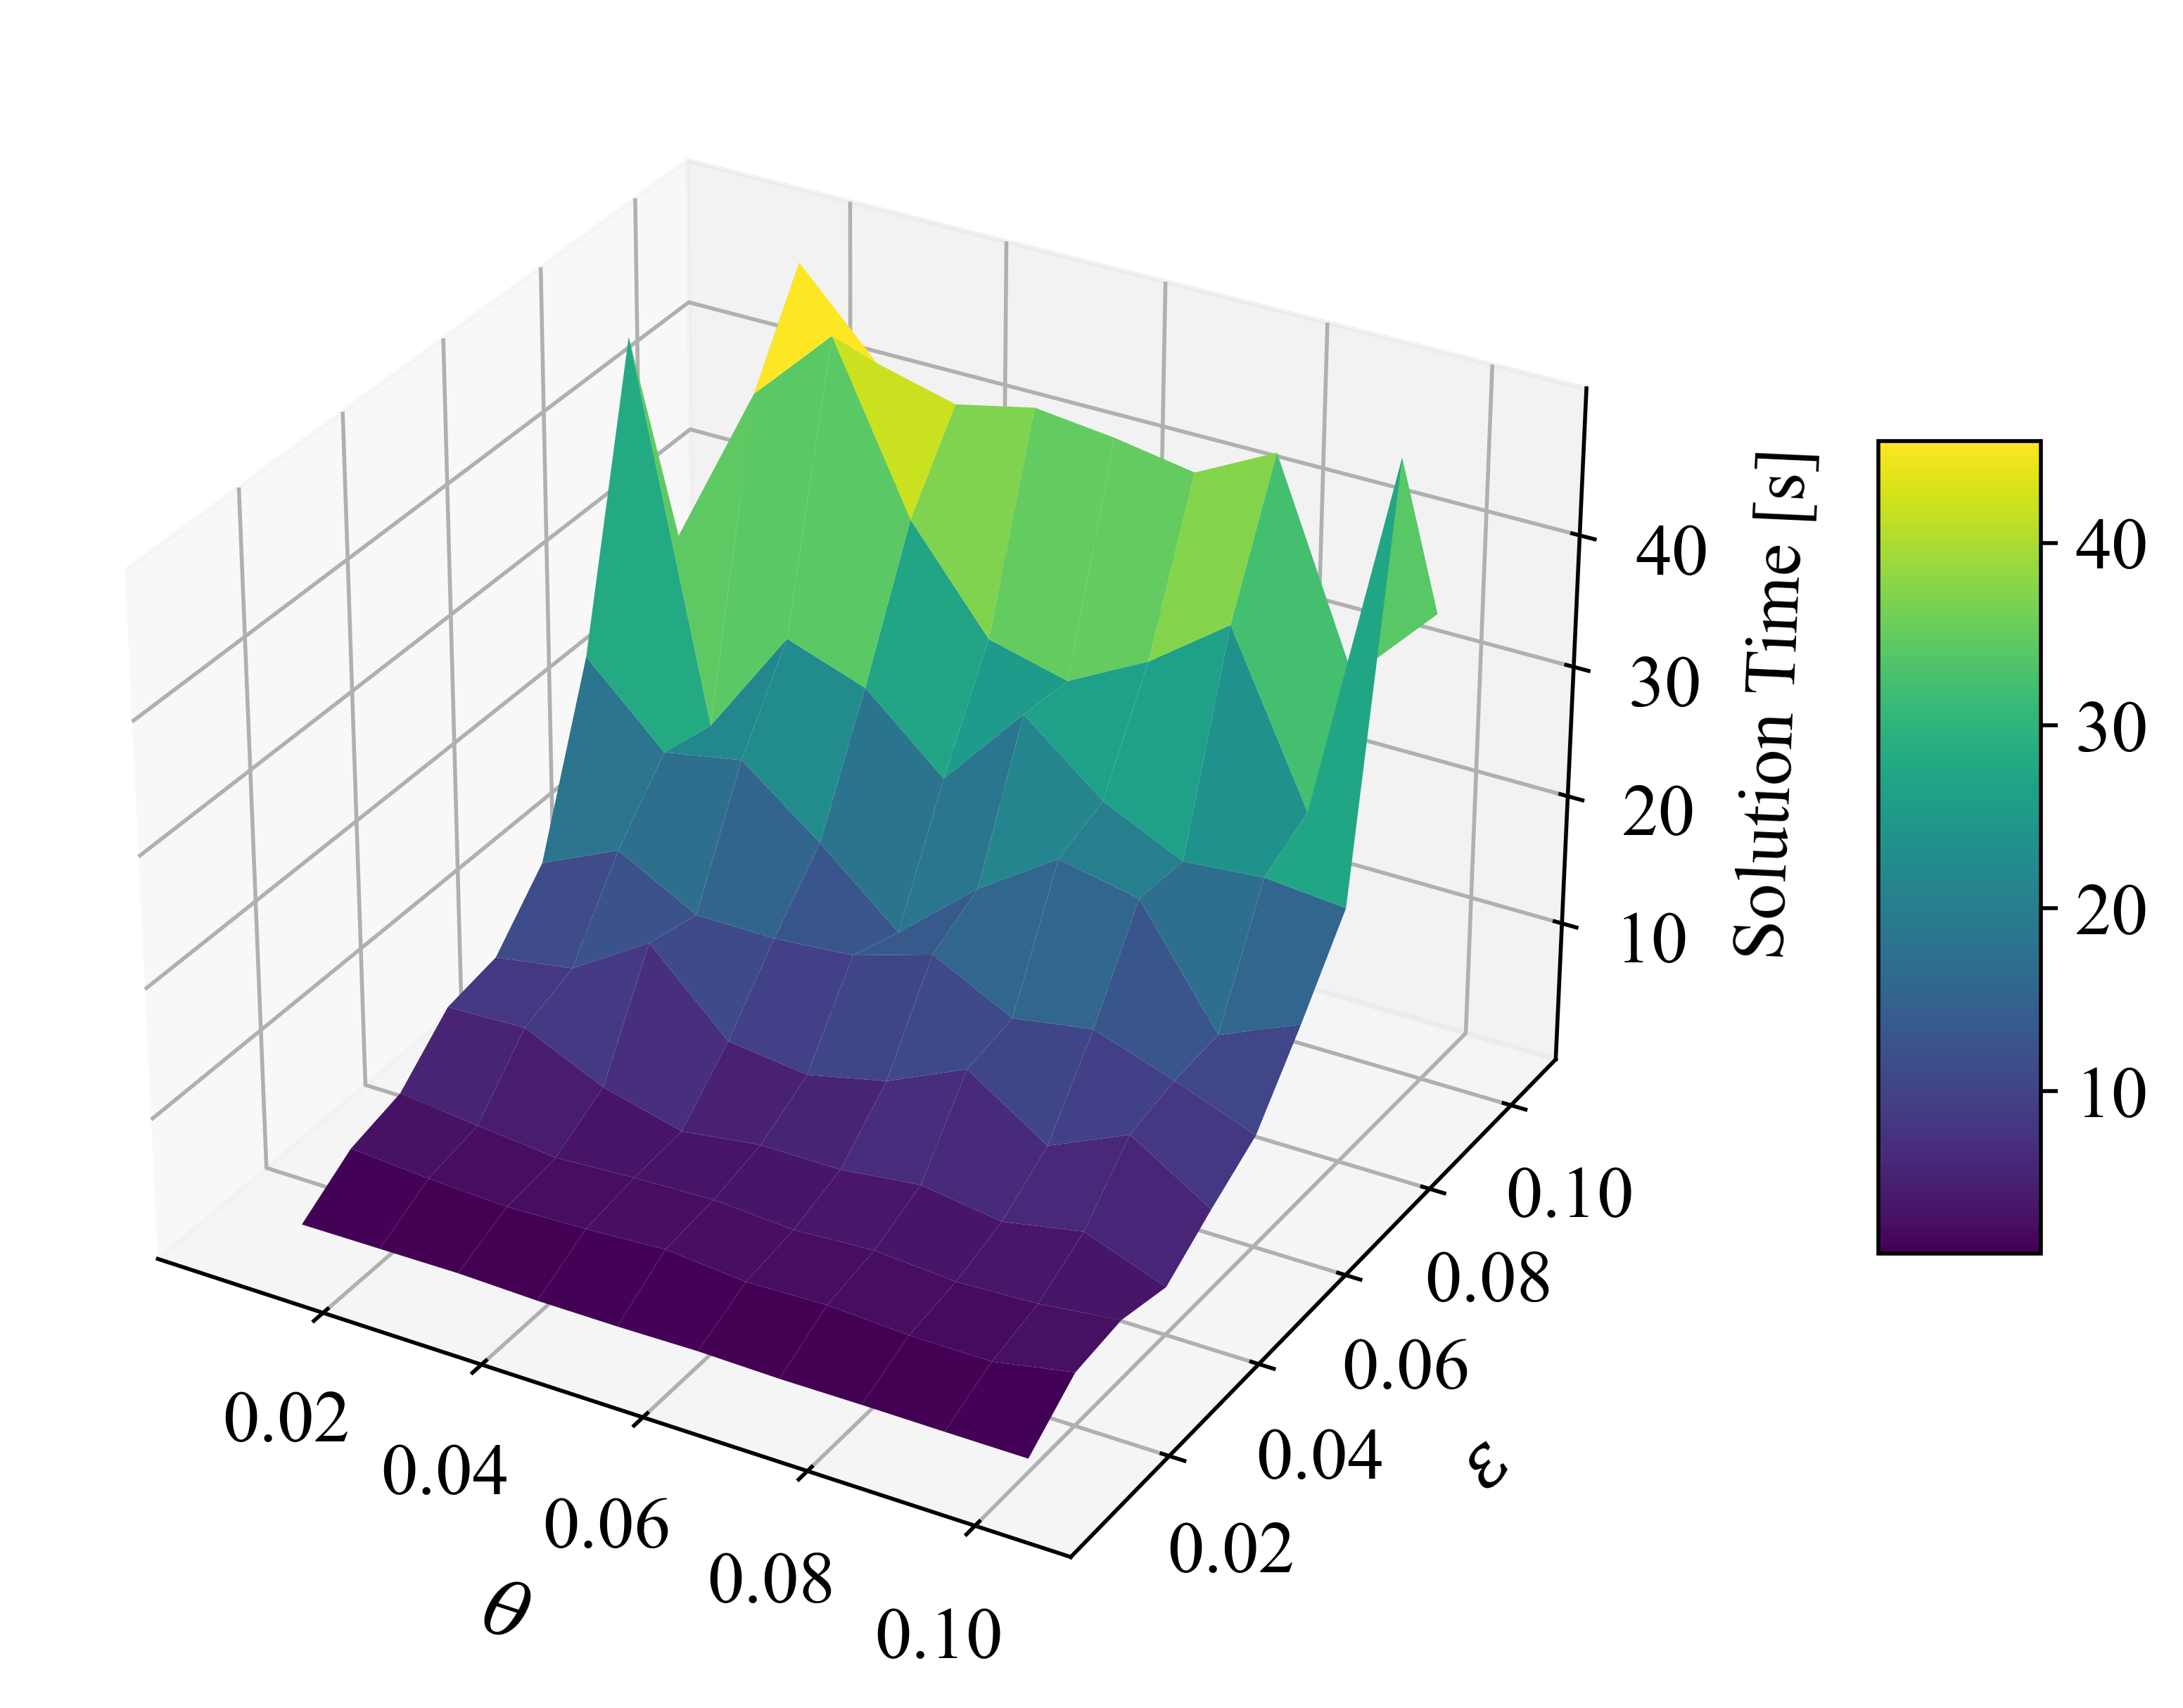

In [21]:
# Since the actual data is not provided, we will create a sample dataframe with random numbers
# to mimic the structure based on the image provided.
x_label = r'$\theta$'
y_label = r'$\epsilon$'
z_label = 'Solution Time [s]'
title = r"Solution Time  via ($\theta$, $\epsilon$)"
file_name = 'Solution Time'
label_name = [x_label, y_label, z_label, title, file_name]

# Create a sample dataframe
data = all_solve_time  # 10x10 matrix as seen in the image
# case_fig.path = "C:/Users/user/OneDrive/1. CODE/IGDT-DRO-optimal-bidding-of-virtual-power-plant"
case_fig.make_3d_plot(data, label_name, save_flag = True)

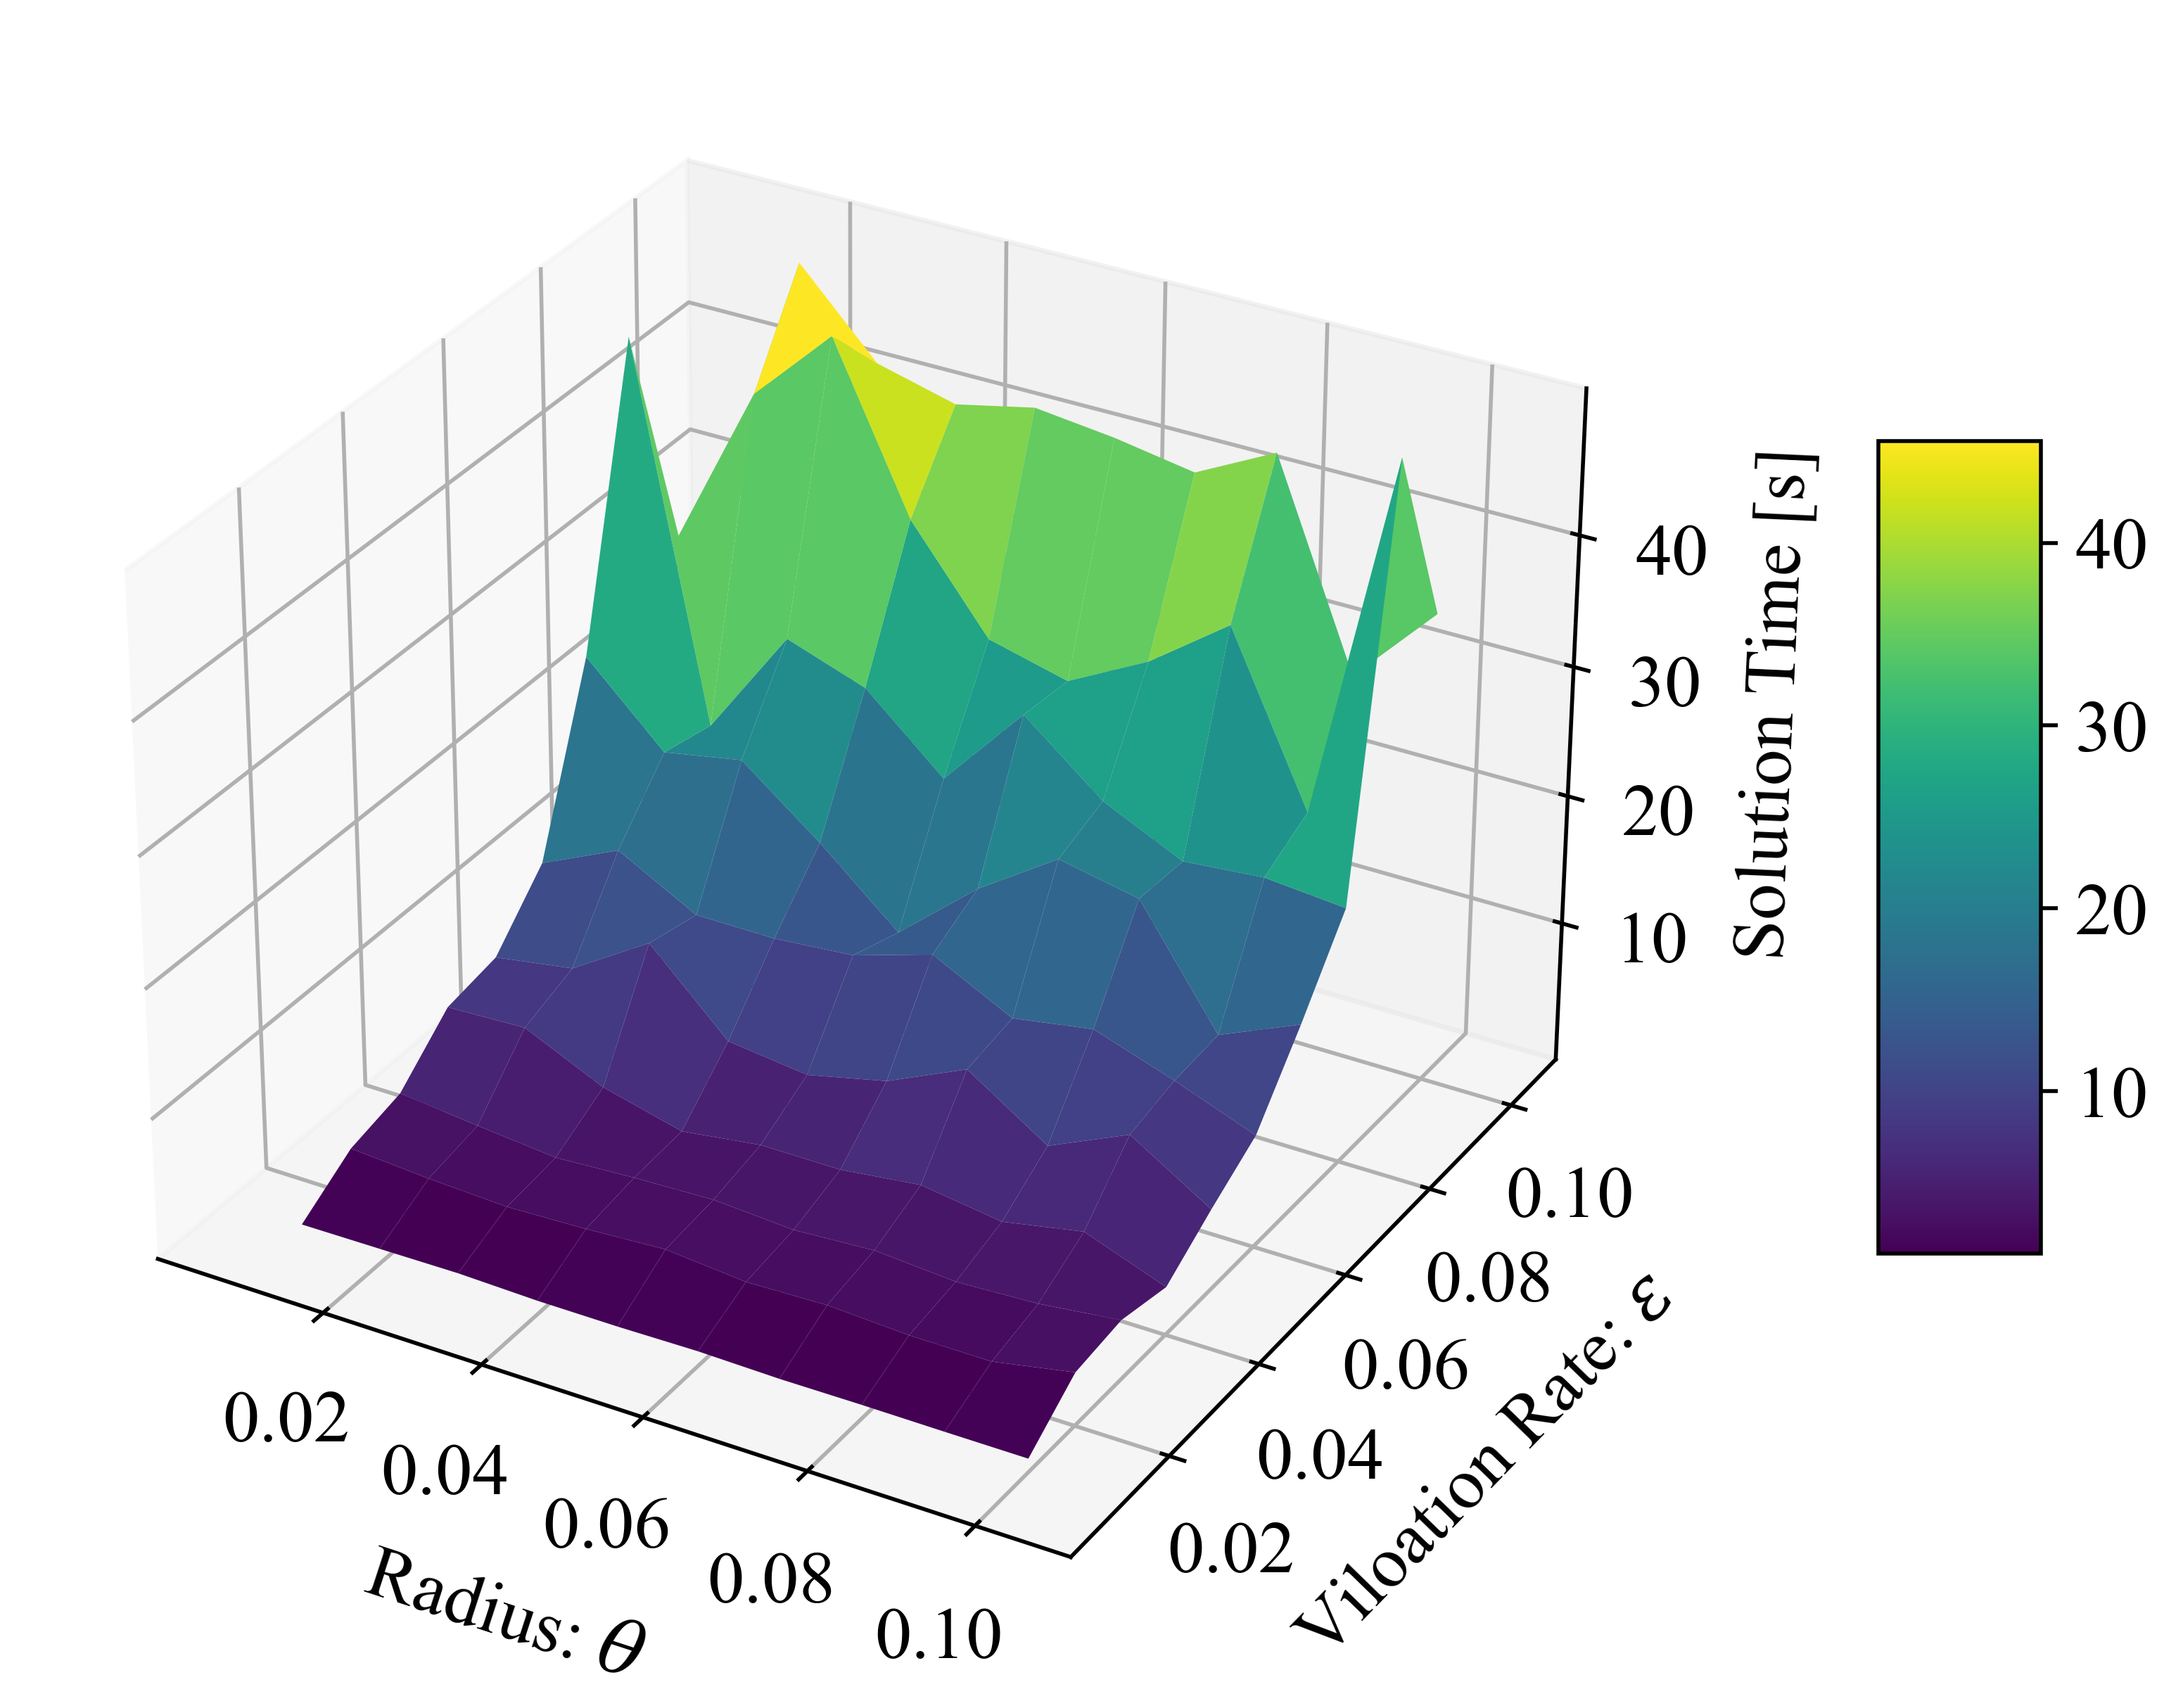

In [22]:
x_label = r'Radius: $\theta$'
y_label = r'Viloation Rate: $\epsilon$'
z_label = 'Solution Time [s]'
title = r"Solution Time  via $\theta$, $\epsilon$"
file_name = 'Soltuion Time'
label_name = [x_label, y_label, z_label, title, file_name]

# Create a sample dataframe
data = all_solve_time  # 10x10 matrix as seen in the image

x_label = label_name[0]
y_label = label_name[1]
z_label = label_name[2]
title = label_name[3]
file_name = label_name[4]

df = pd.DataFrame(data)

# Initialize a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Create coordinate arrays for the dataframe values
X = np.arange(df.shape[1])*0.01 + 0.01
Y = np.arange(df.shape[0])*0.01 + 0.01
X, Y = np.meshgrid(X, Y)
Z = df.values

# Plotting the 3D surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.1)

# Set labels
ax.set_xlabel(x_label, labelpad=10) # labelpad 값을 조정하여 레이블과 눈금 사이의 거리를 조절할 수 있습니다.
ax.set_ylabel(y_label, labelpad=10) # labelpad 값을 조정하여 레이블과 눈금 사이의 거리를 조절할 수 있습니다.
ax.set_zlabel(z_label, labelpad=5)

# Show the plot
plt.savefig("C:/Users/user/OneDrive/1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant/fig/test.png", dpi = 500, bbox_inches='tight')
plt.show()


save the fig at location : C:\Users\user\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


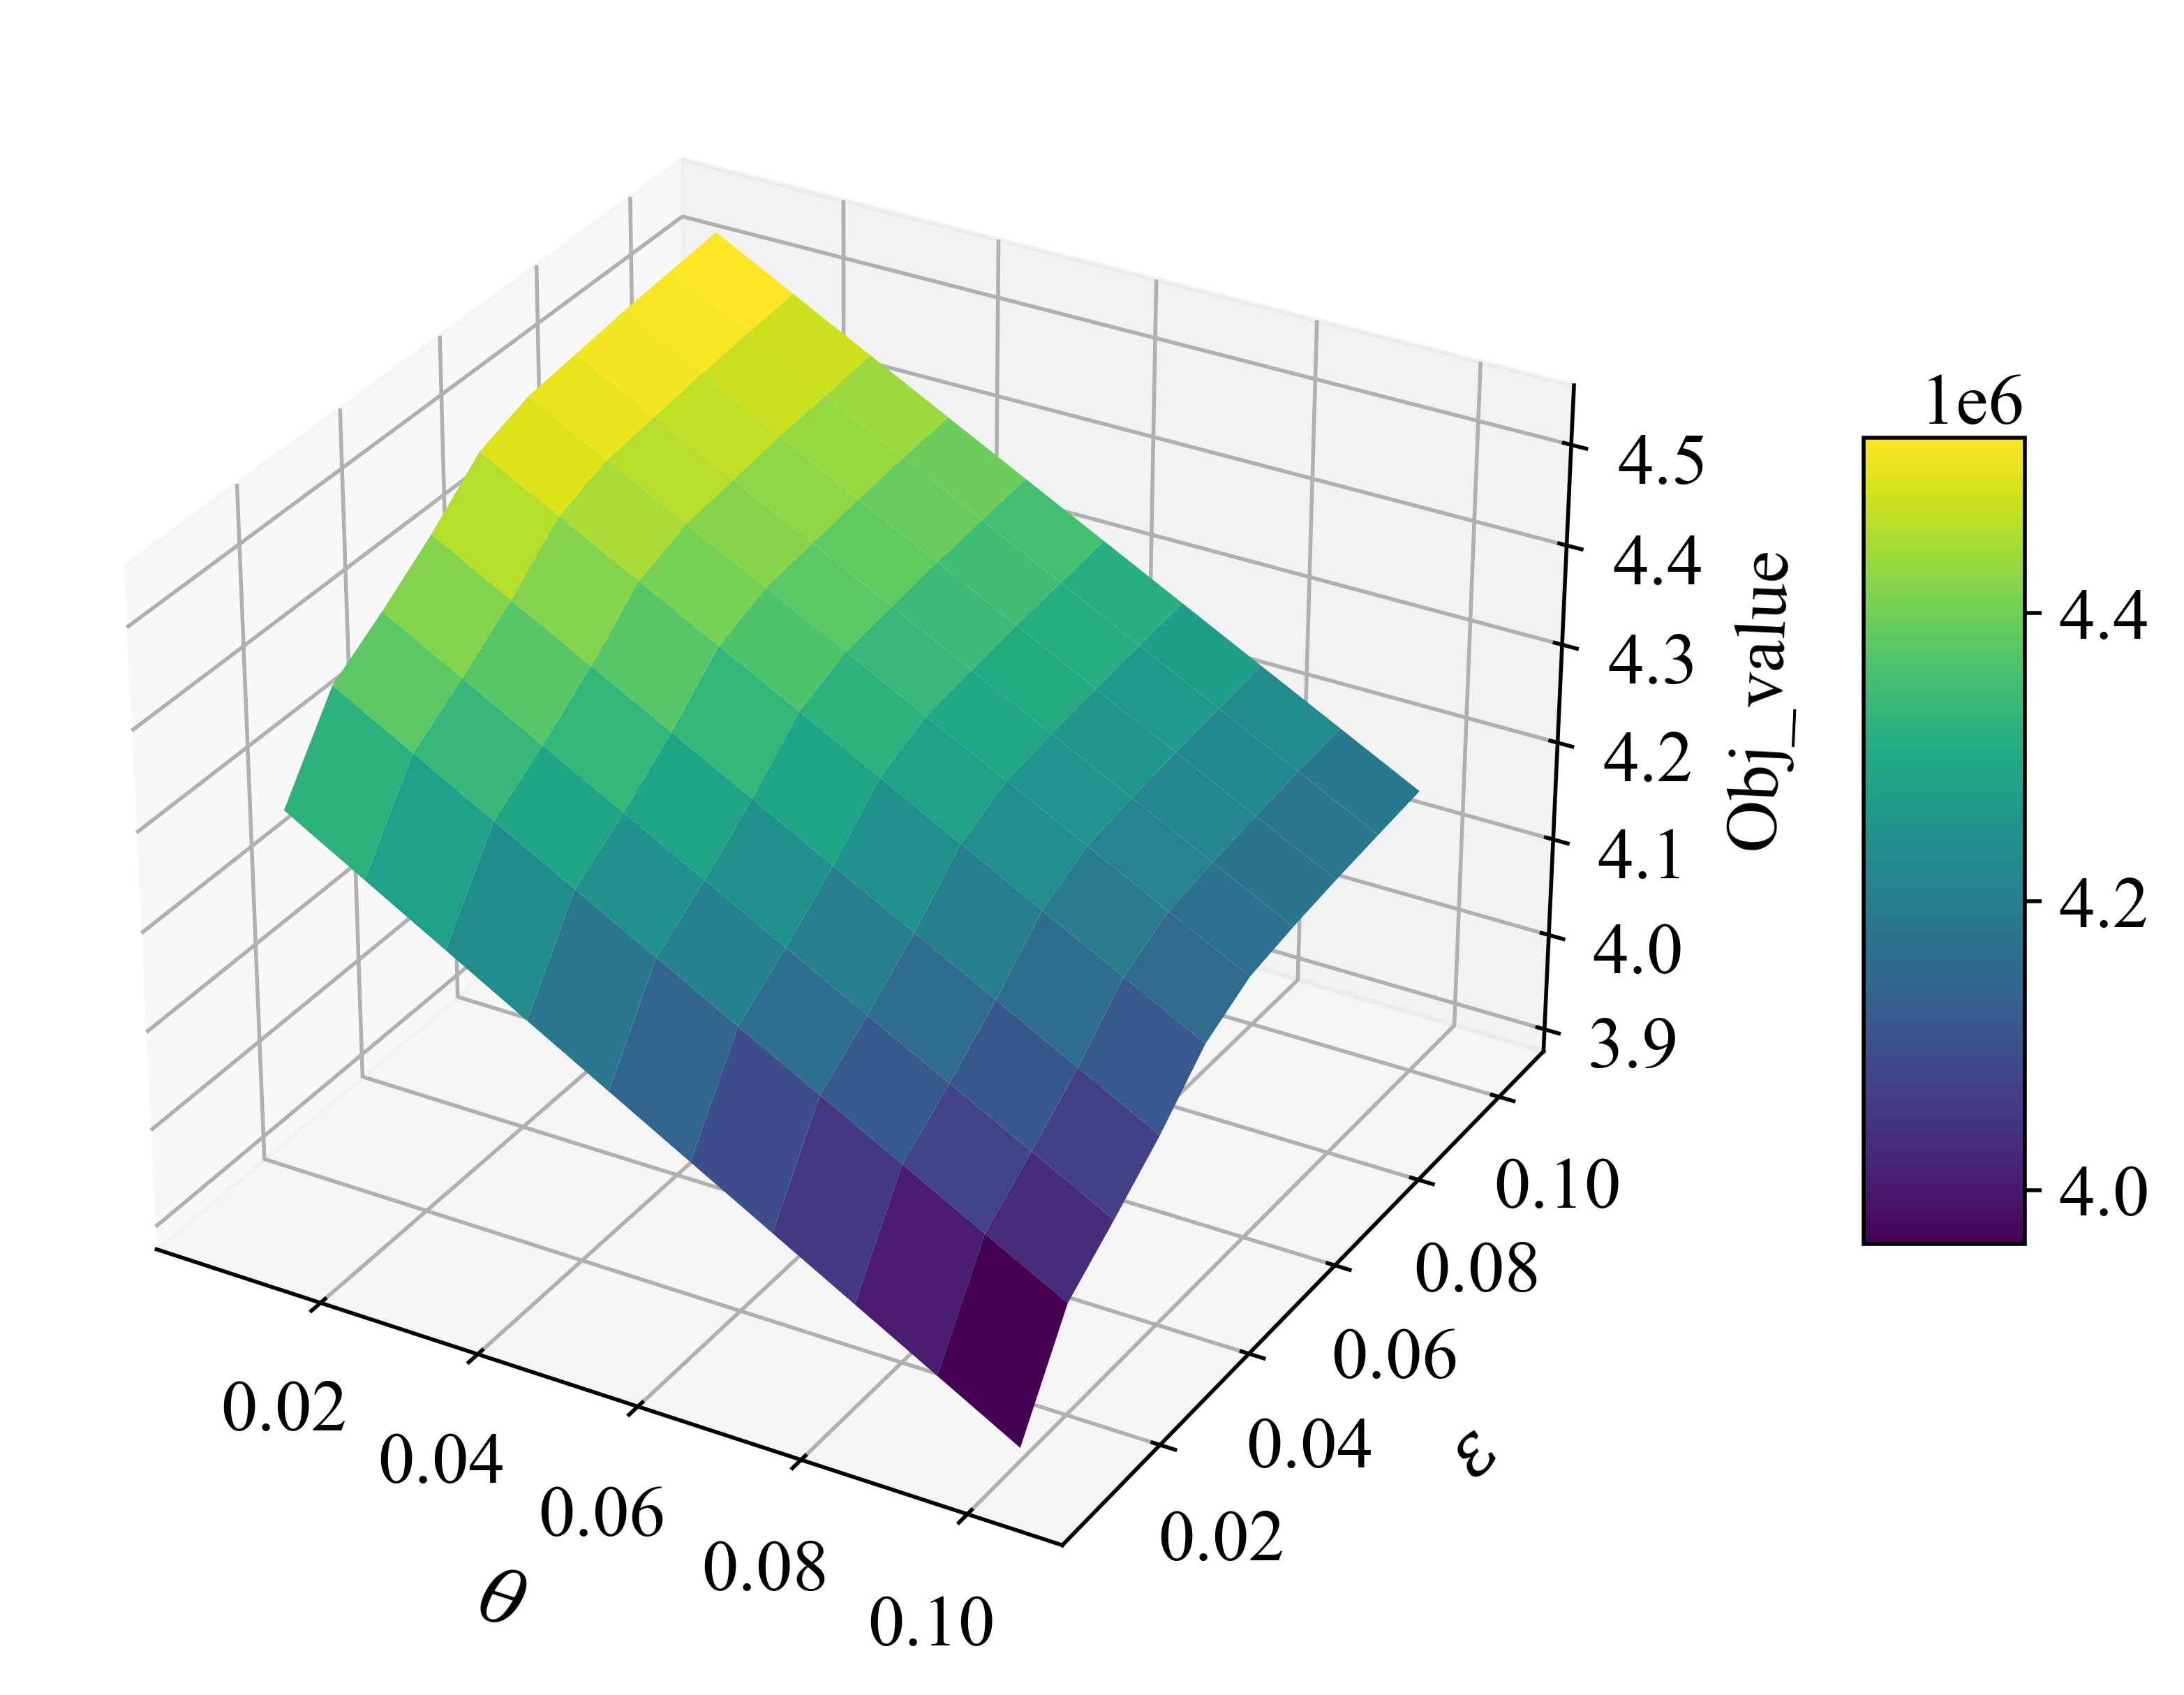

In [23]:
# Since the actual data is not provided, we will create a sample dataframe with random numbers
# to mimic the structure based on the image provided.

# Create a sample dataframe
data = all_objVal  # 10x10 matrix as seen in the image

x_label = r'$\theta$'
y_label = r'$\epsilon$'
z_label = 'Obj_value'
title = r"Objective Value via $\theta$, $\epsilon$"
file_name = 'wdrcc_objective_value'
label_name = [x_label, y_label, z_label, title, file_name]

# Create a sample dataframe
case_fig.make_3d_plot(data, label_name, save_flag = True)

save the fig at location : C:\Users\user\OneDrive\1. CODE\IGDT-DRO-optimal-bidding-of-virtual-power-plant


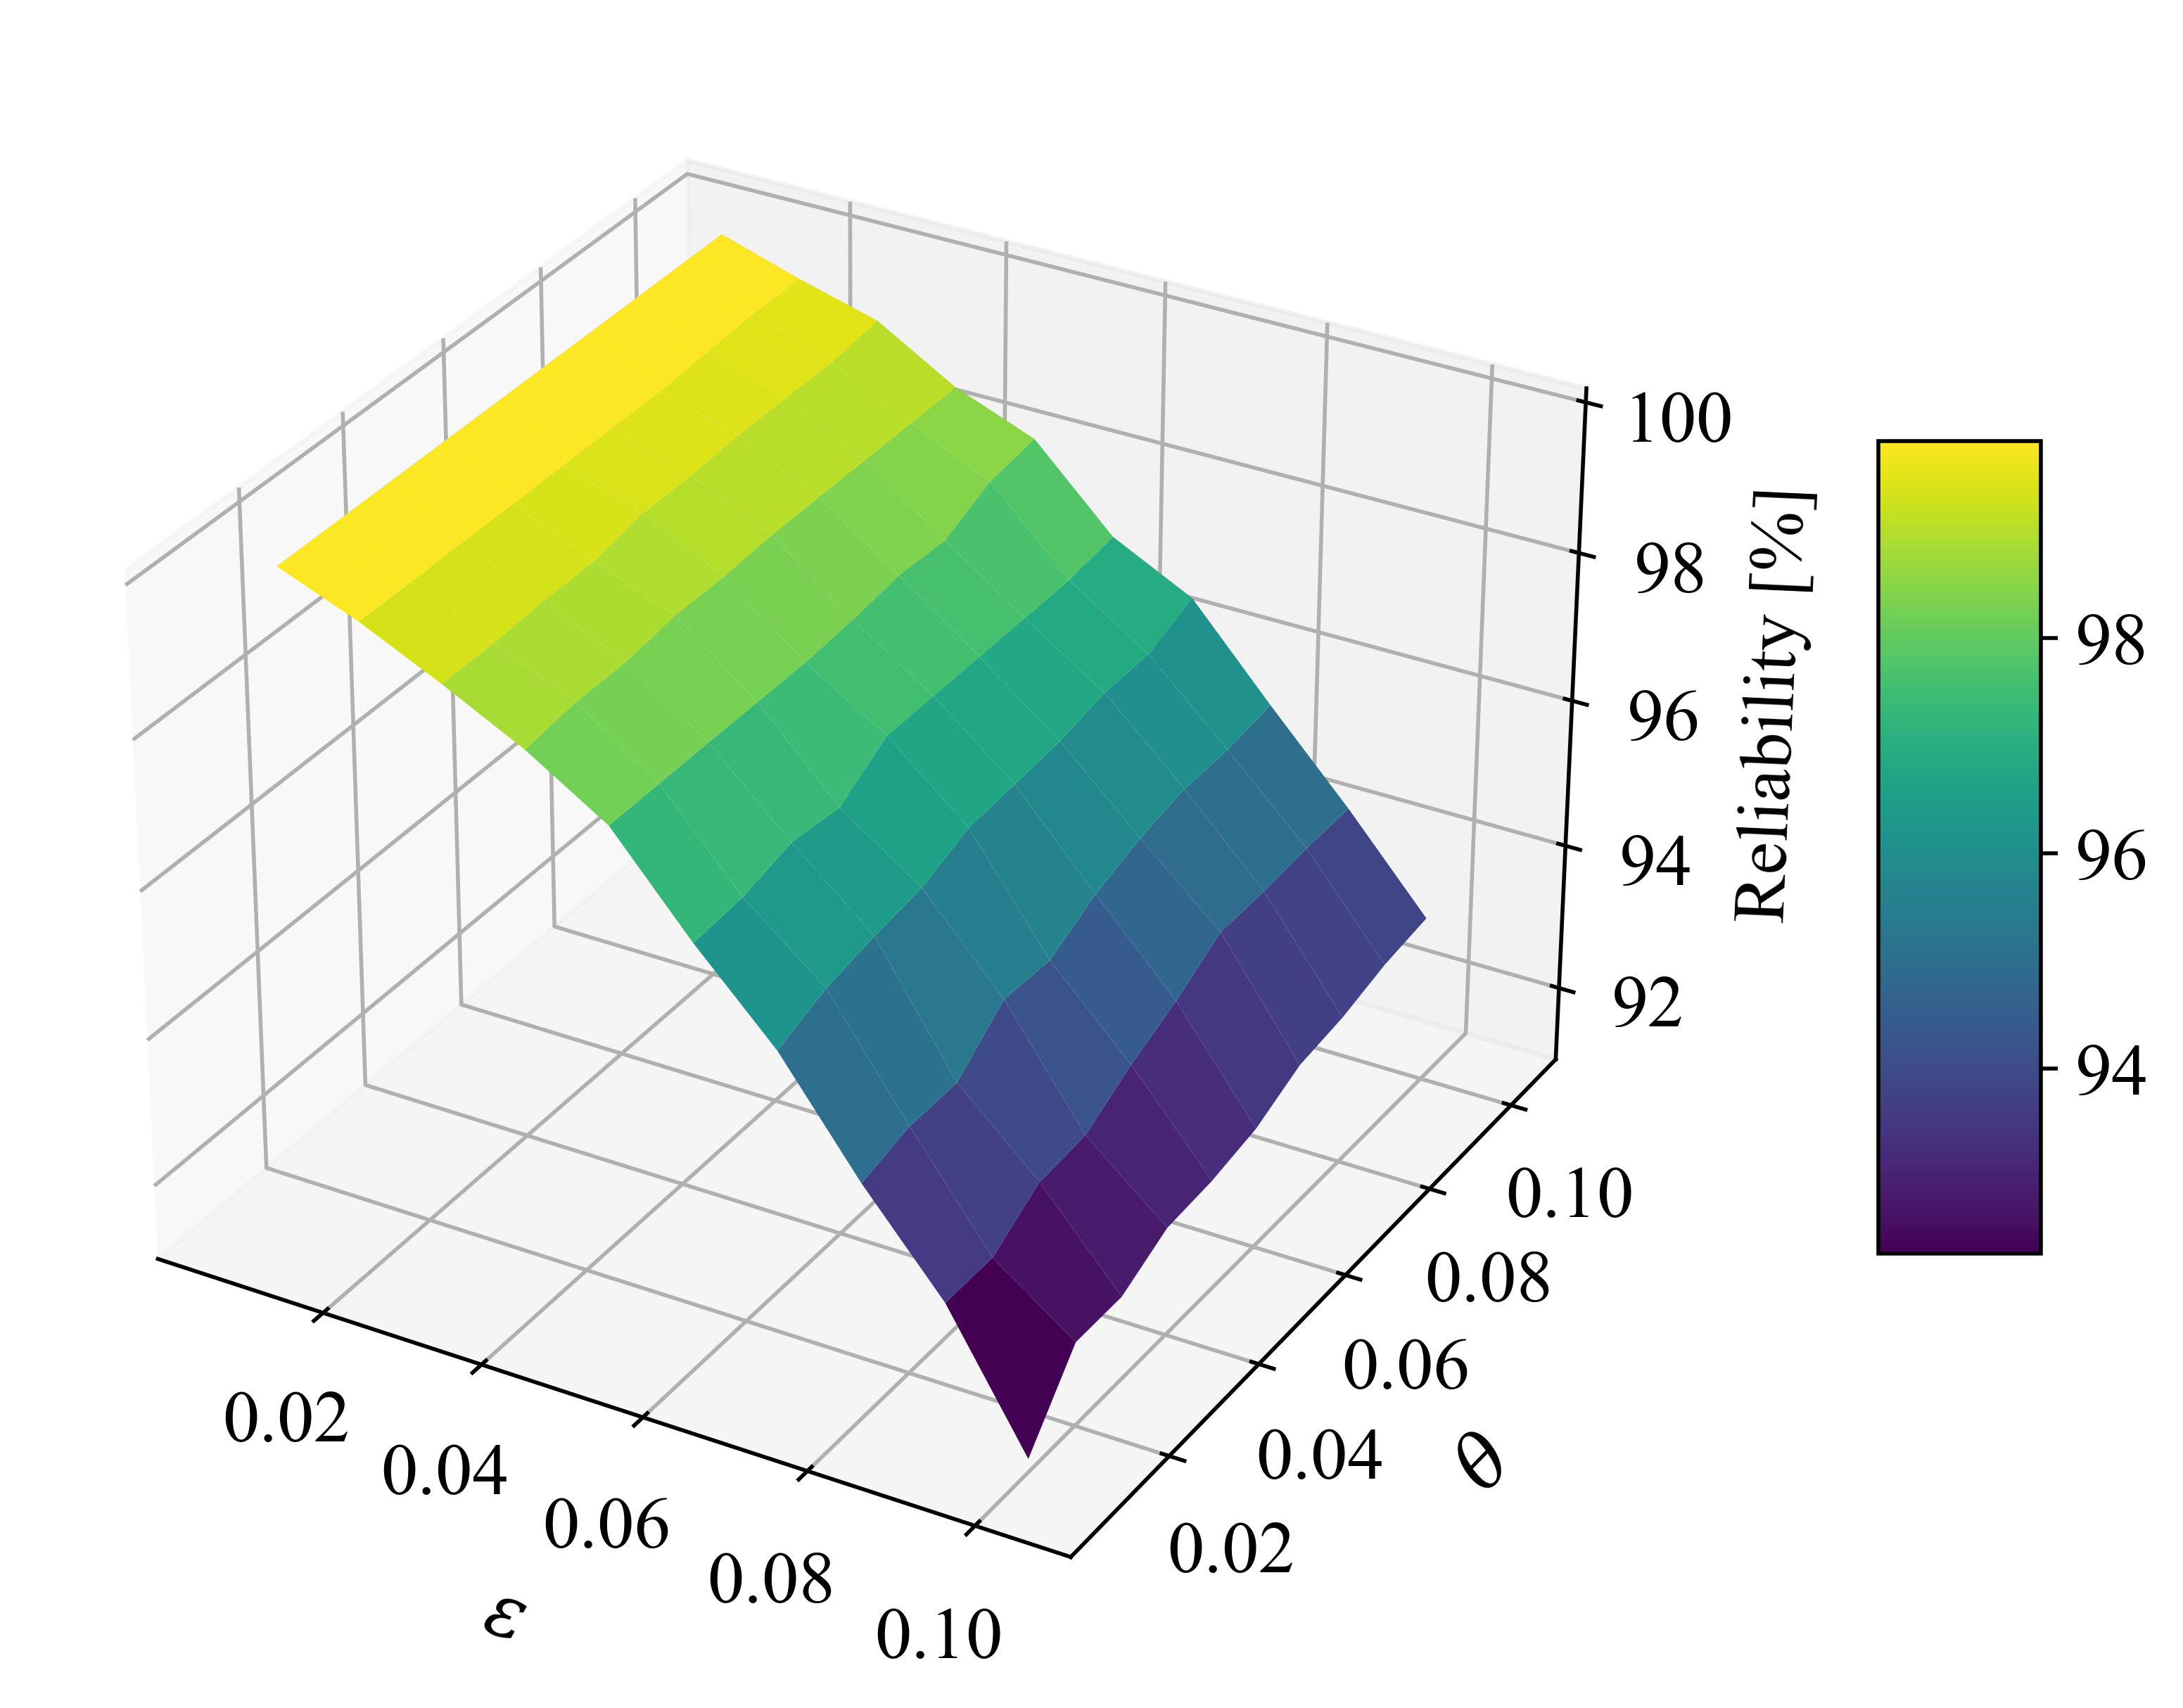

In [24]:
# Since the actual data is not provided, we will create a sample dataframe with random numbers
# to mimic the structure based on the image provided.

# Create a sample dataframe
data = all_reliable  # 10x10 matrix as seen in the image
data = np.array(data).transpose()

x_label = r'$ \epsilon$'
y_label = r'$\theta$'
z_label = 'Reliability [%]'
title = r"Reliability $(1-\rho) \times 100$ [%] via $\theta$, $\epsillon$"
file_name = 'reliability'
label_name = [x_label, y_label, z_label, title, file_name]

# Create a sample dataframe
case_fig.make_3d_plot(data, label_name, save_flag = True)

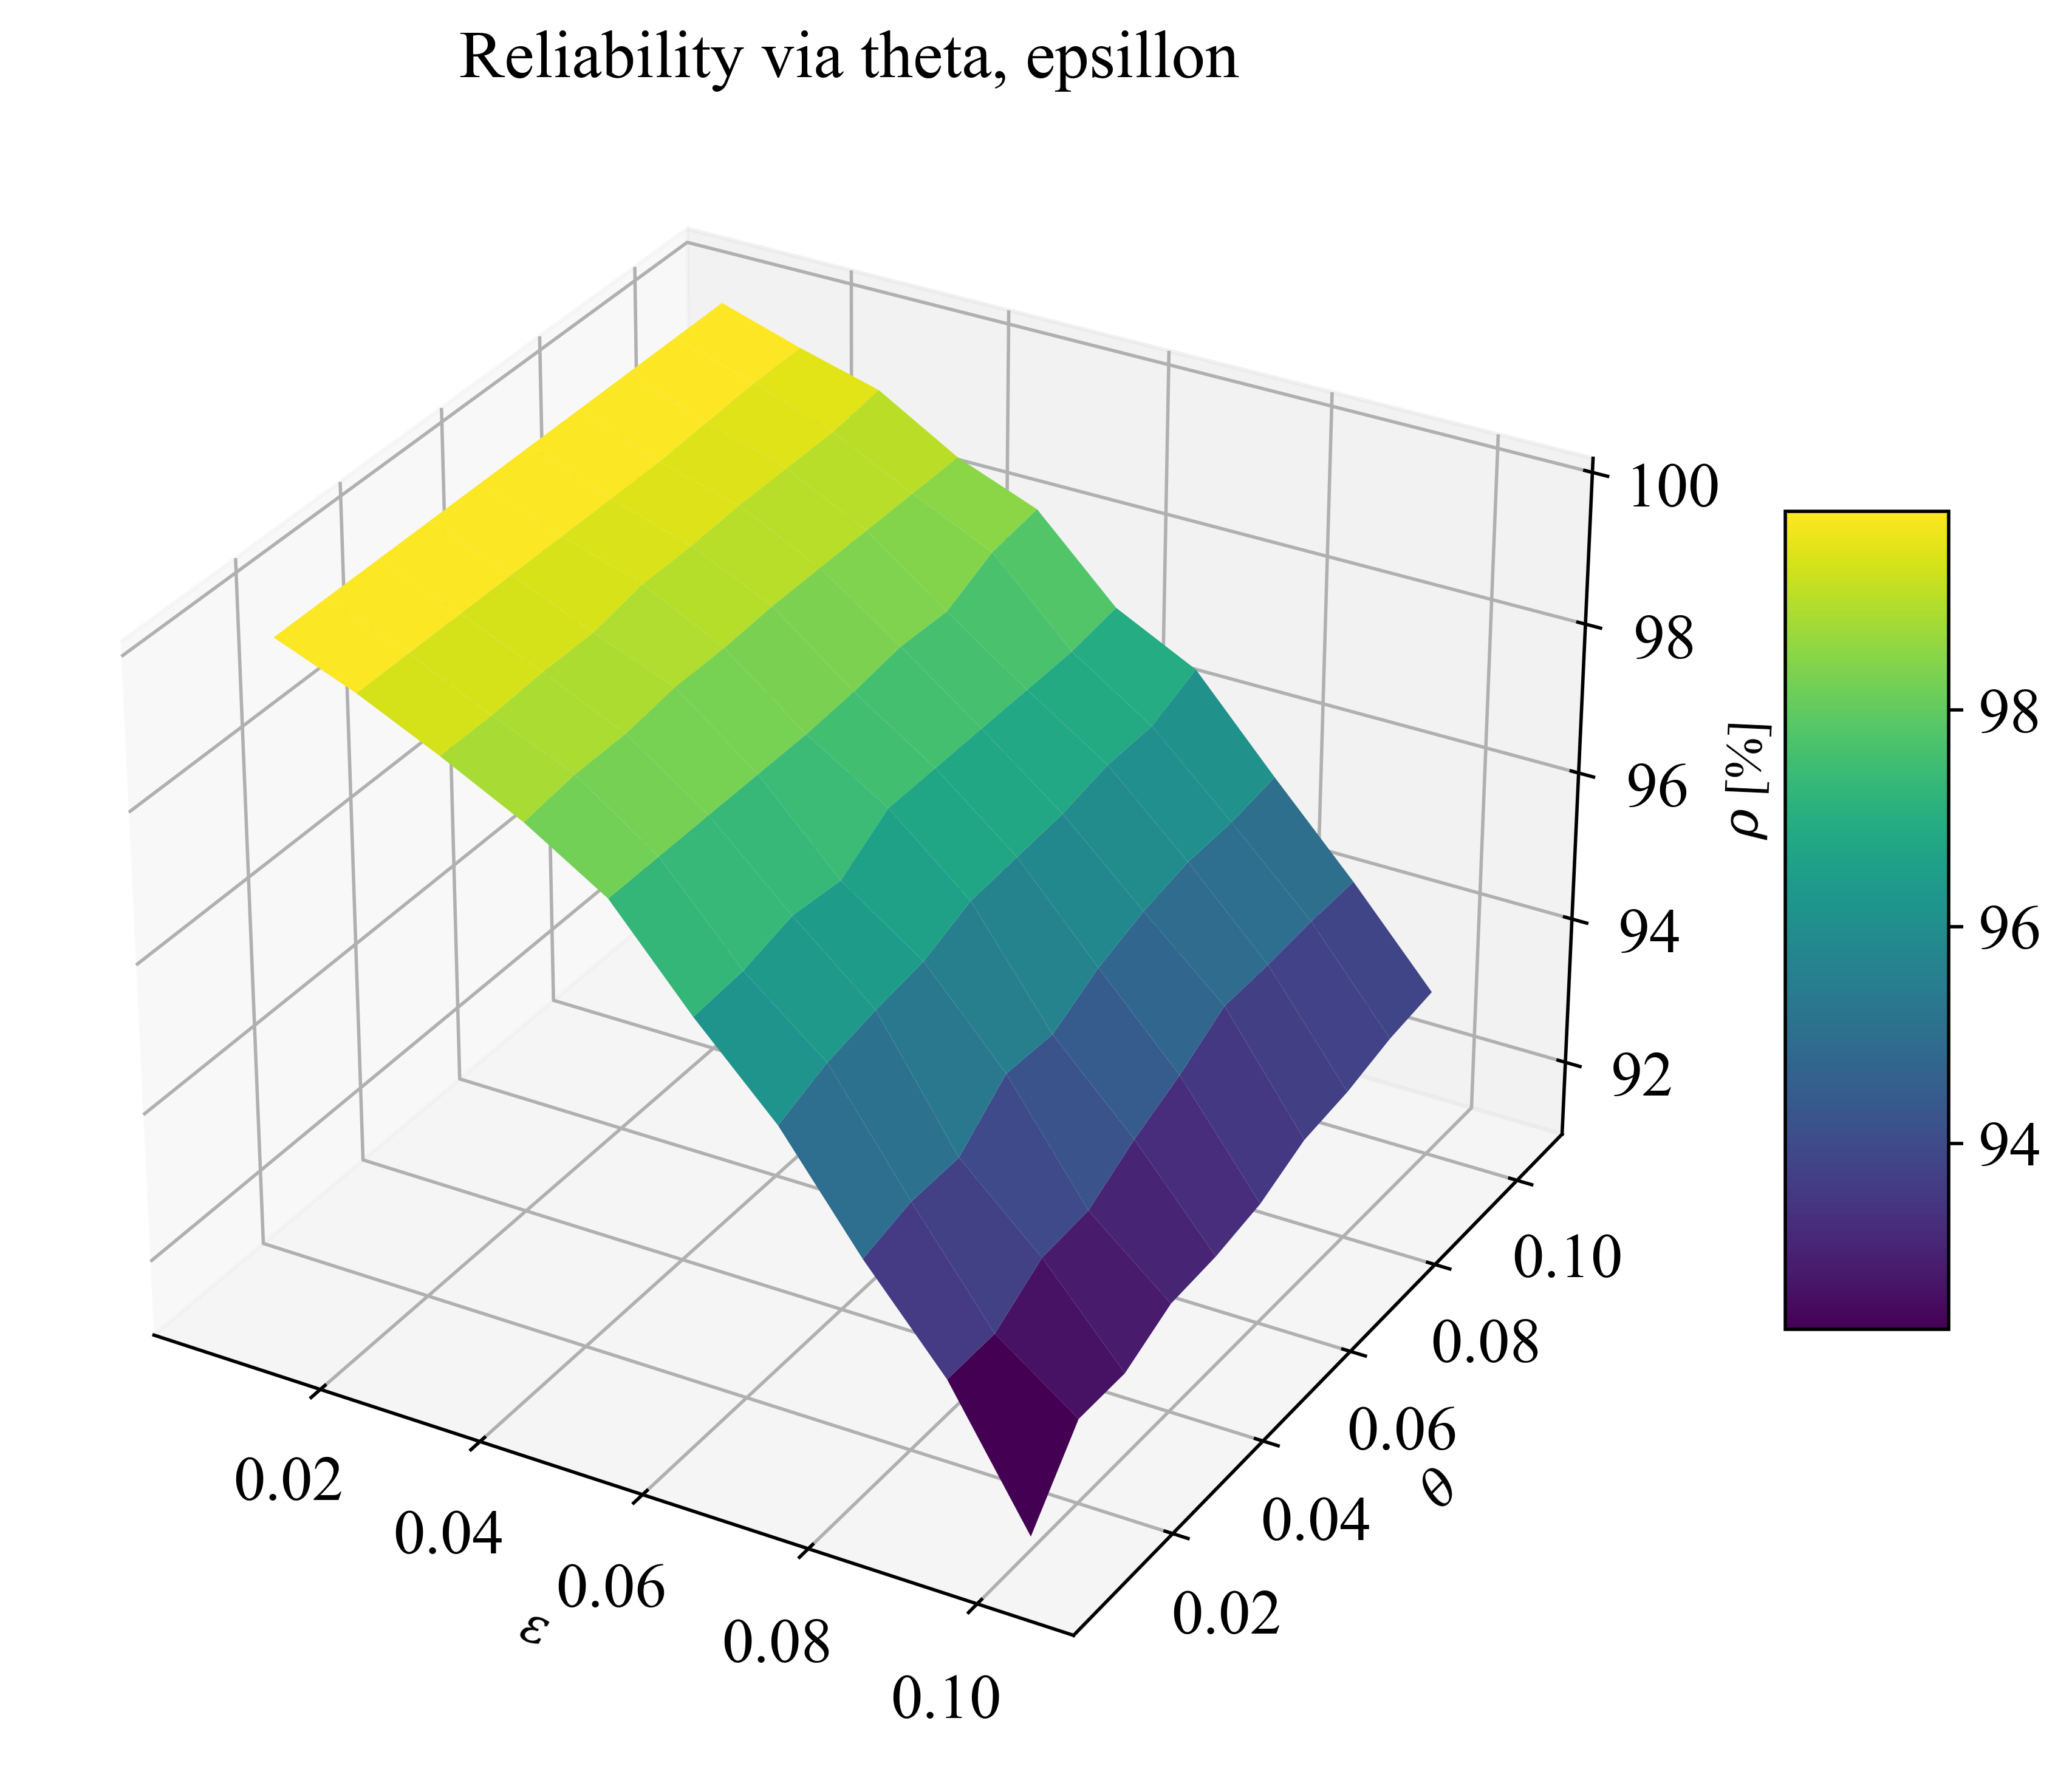

In [25]:
# Since the actual data is not provided, we will create a sample dataframe with random numbers
# to mimic the structure based on the image provided.

# Create a sample dataframe
data = all_reliable  # 10x10 matrix as seen in the image
data = np.array(data).transpose()
df = pd.DataFrame(data)

# Initialize a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create coordinate arrays for the dataframe values
X = np.arange(df.shape[1])*0.01 + 0.01
Y = np.arange(df.shape[0])*0.01 + 0.01
X, Y = np.meshgrid(X, Y)
Z = df.values

# Plotting the 3D surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

# Set labels
ax.set_ylabel(r'$\theta$', fontsize=12)
ax.set_xlabel(r'$ \epsilon$', fontsize=12)
ax.set_zlabel(r'$\rho $ [%]', fontsize=12)
ax.set_title("Reliability via theta, epsillon", fontsize=16)

# Show the plot
plt.show()

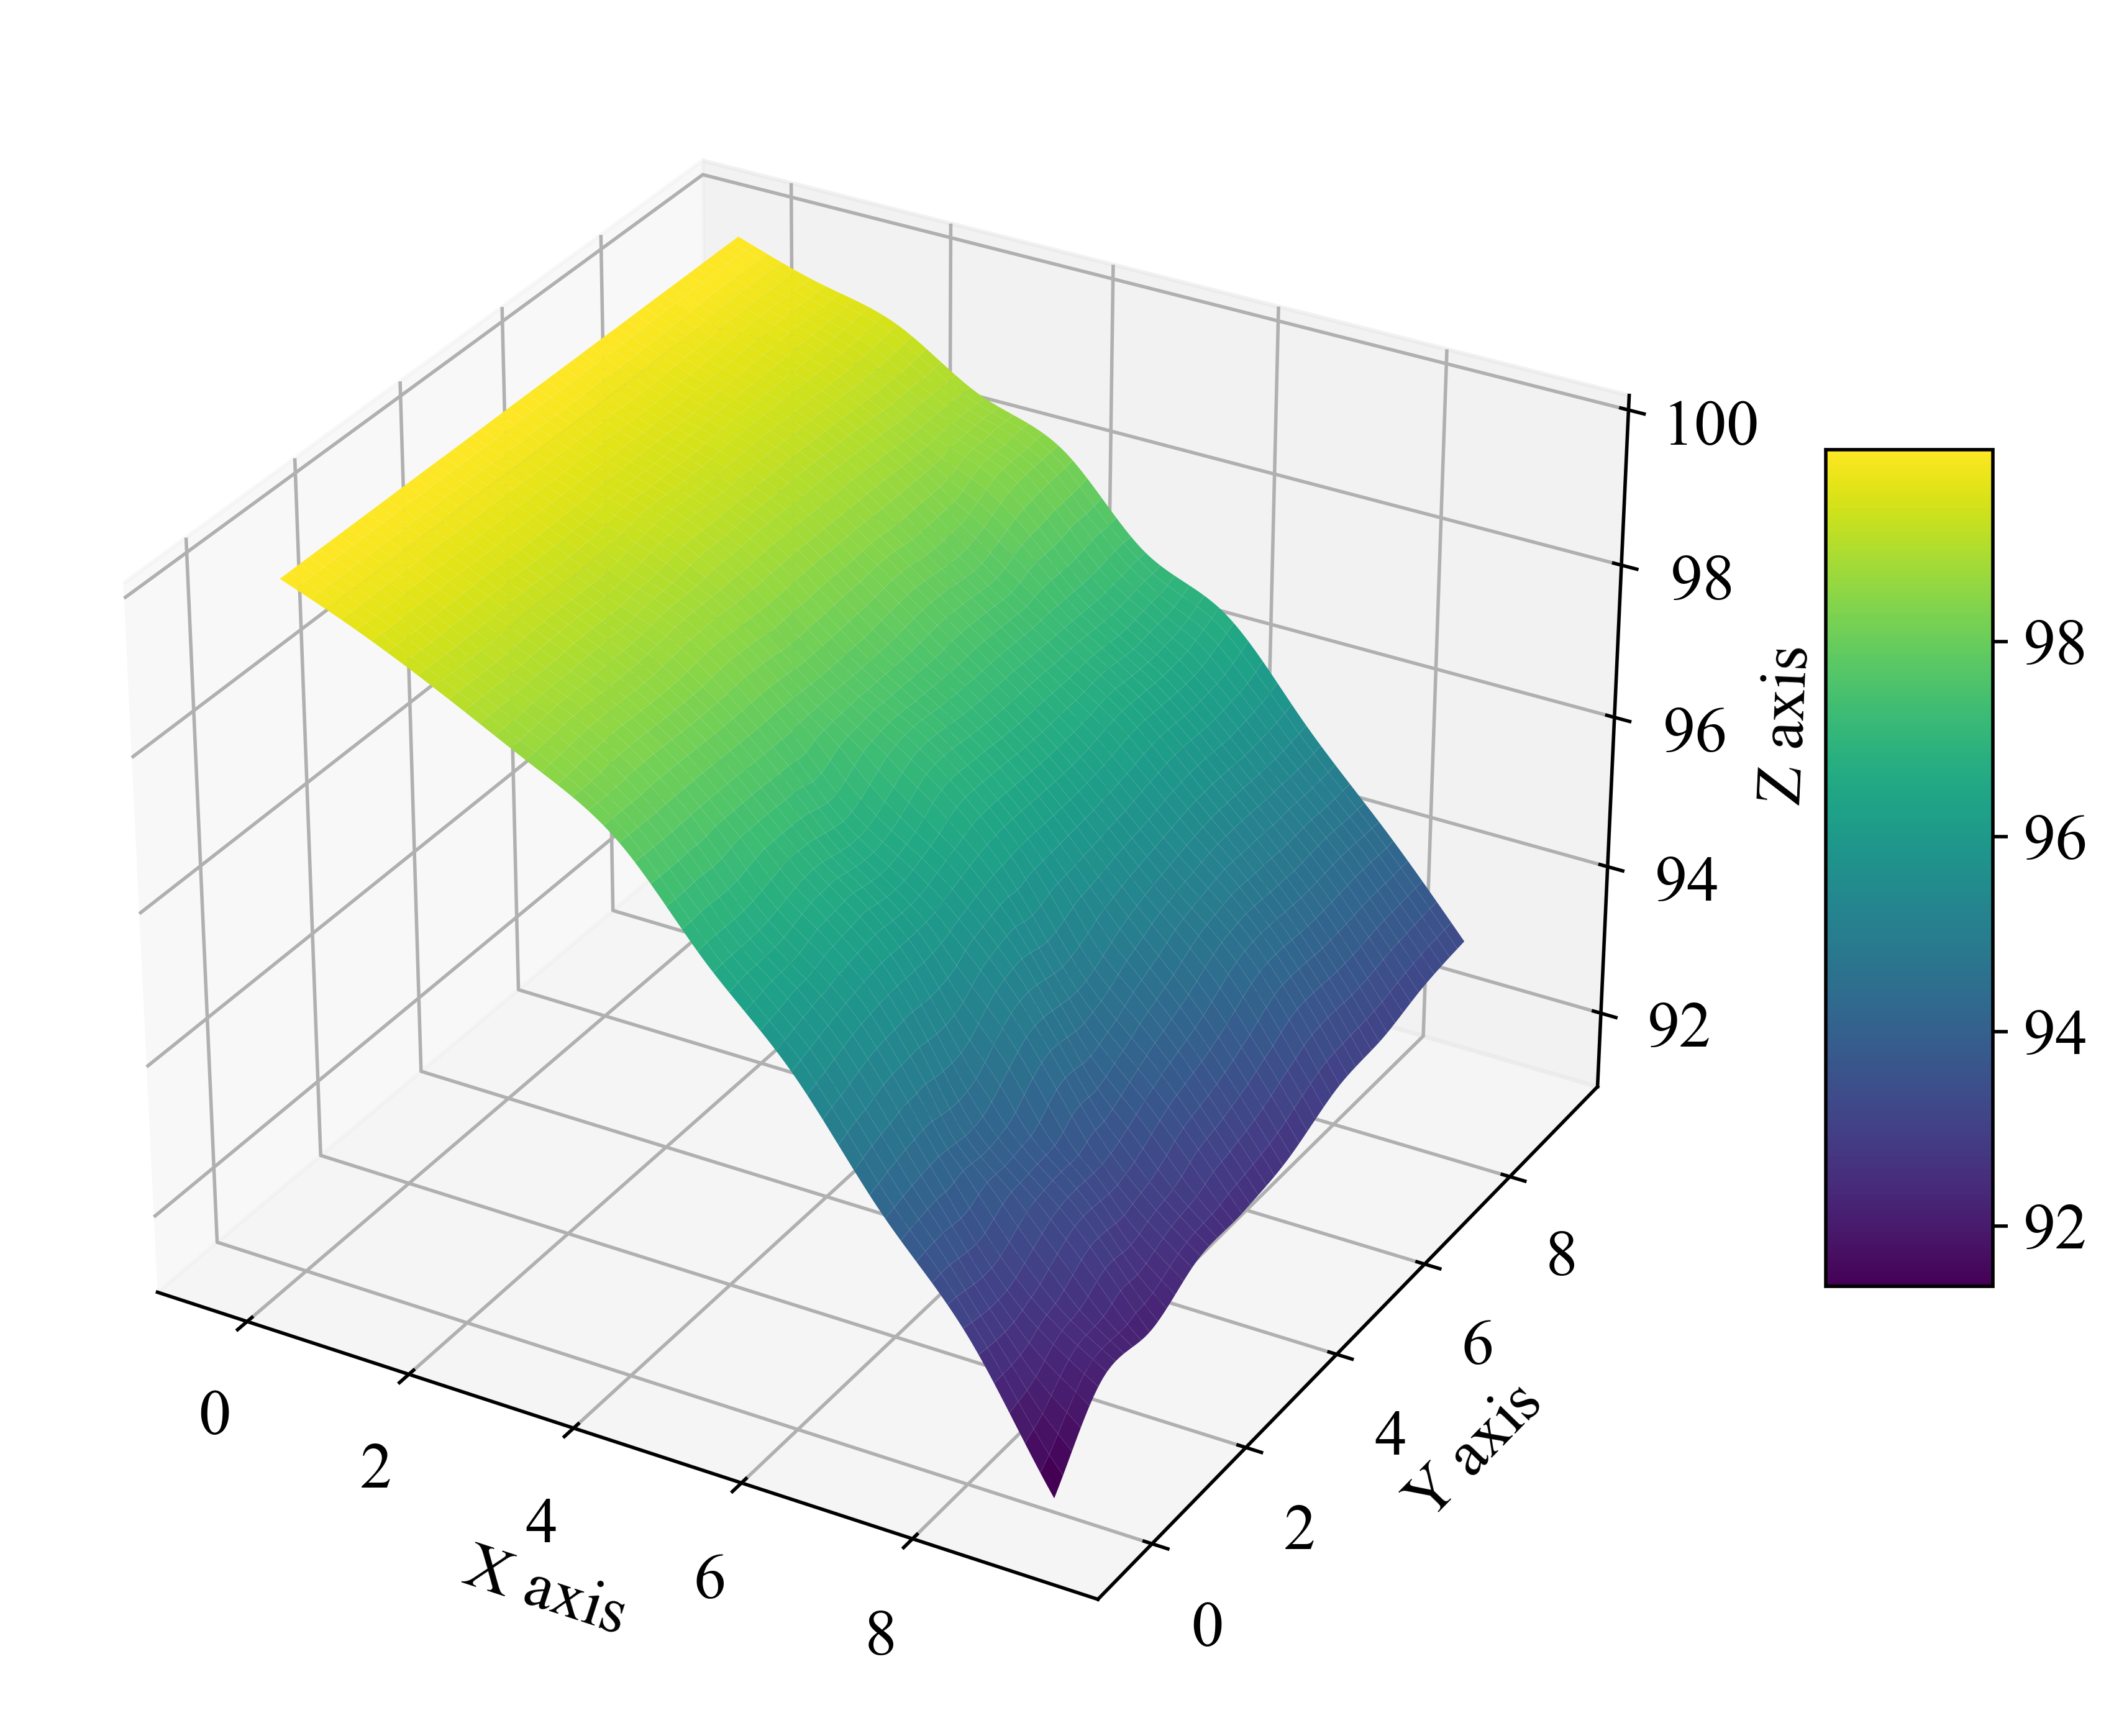

In [26]:
# To make the surface plot smoother, we can interpolate the data
# to create a finer grid before plotting.

from scipy.interpolate import griddata

# Create a dataframe again
data = all_reliable  # 10x10 matrix as seen in the image
data = np.array(data).transpose()
df = pd.DataFrame(data)

# Create the grid coordinates for interpolation
X = np.arange(df.shape[1])
Y = np.arange(df.shape[0])
X, Y = np.meshgrid(X, Y)
Z = df.values.flatten()

# Interpolation grid
xi = np.linspace(X.min(), X.max(), 500)
yi = np.linspace(Y.min(), Y.max(), 500)
xi, yi = np.meshgrid(xi, yi)

# Interpolate; this creates a smooth surface
Zi = griddata((X.flatten(), Y.flatten()), Z, (xi, yi), method='cubic')

# Plotting the smooth surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xi, yi, Zi, cmap='viridis', edgecolor='none')

# Color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

# Labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the plot
plt.show()